<h1 style="text-align: center;">Energy Forecaster</h1>
<h3 style="text-align: center;">Part One: Data exploration and preprocessing</h3>

## Import Packages

In [ ]:
!pip3.11 install seaborn

In [643]:
import os
import random
import csv
import seaborn
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pandas import DataFrame
from matplotlib import pyplot as plt

## Ignore warnings

In [644]:
# filter and ignore warnings
warnings.filterwarnings('ignore')

## Define Methods & Constants

In [645]:
def load_txt(file_path: str) -> list:
    """Loads text file that contains all file names that contain headers"""
    file_paths_list = []
    with open(file_path, newline='') as file:
        for file_path in list(csv.reader(file)):
            file_paths_list.append(file_path[0])
    return file_paths_list

In [646]:
COLCHESTER_DATA_DIR = "./Data/Colchester"
BRIGHTON_DATA_DIR = "./Data/Brighton"
DATA_FILES_WITH_HEADERS_PATH = "./Data/dataFilesWithHeaders.txt"

LIST_DATA_FILE_PATHS_WITH_HEADERS = load_txt(DATA_FILES_WITH_HEADERS_PATH)

SIN_COS_PERIOD_MONTH = 12
SIN_COS_PERIOD_HOUR = 24
SIN_COS_PERIOD_DAY = 365

FEATURES_COLS_WIND = ["temp", "dew", 'humidity', 'precip', 'precipprob', "winddir", 'sealevelpressure',
                      "cloudcover", 'month_sin', 'month_cos', 'hour_sin', "hour_cos", "day_sin", "day_cos"]
FEATURES_COLS_SOLAR = ["temp", "dew", 'humidity', 'precip', 'precipprob', 'sealevelpressure',
                       'cloudcover', "uvindex", 'month_sin', 'month_cos', 'hour_sin', "hour_cos", "day_sin",
                        "day_cos"]

LABEL_COL_WIND = ["windspeed"]
LABEL_COL_SOLAR = ["solarradiation"]

In [647]:
def create_df_from_multiple_csvs(directory_path: str, new_file_name: str) -> DataFrame:
    """Read multiple csvs files and merge them into a dataframe"""
    df_list, file_paths_list = [], []
    for subdir, dirs, files in os.walk(directory_path):
        for file in sorted(files):
            # create file path             
            file_path = subdir + os.sep + file
            # skip .DS_Store files             
            if not file_path.endswith(".DS_Store"):
                if file_path in LIST_DATA_FILE_PATHS_WITH_HEADERS:
                    # set header if file has headers                     
                    df = pd.read_csv(file_path, header=1)
                else:
                    df = pd.read_csv(file_path)
                    
                df_list.append(df)
    # merge all dataframes
    df = pd.concat(df_list, axis=0)
    df.to_csv(new_file_name, encoding='utf-8', index=False)
                
    return df

In [648]:
def sin_transformer(period: int) -> FunctionTransformer:
    """
    Returns a transformer that applies sine transformation to a variable using
    the specified period.
    """
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period: int) -> FunctionTransformer:
    """
    Returns a transformer that applies cosine transformation to a variable using
    the specified period.
    """
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [649]:
def encode_datetime(df: DataFrame) -> None:
    """Encode month, day and hour uisng sine-cosine encoding"""
    df["month"] = df.index.month
    df["month_sin"] = sin_transformer(SIN_COS_PERIOD_MONTH).fit_transform(df["month"])
    df["month_cos"] = cos_transformer(SIN_COS_PERIOD_MONTH).fit_transform(df["month"])
    
    df["hour"] = df.index.hour
    df["hour_sin"] = sin_transformer(SIN_COS_PERIOD_HOUR).fit_transform(df["hour"])
    df["hour_cos"] = cos_transformer(SIN_COS_PERIOD_HOUR).fit_transform(df["hour"])
    
    df["day"] = df.index.day
    df["day_sin"] = sin_transformer(SIN_COS_PERIOD_DAY).fit_transform(df["day"])
    df["day_cos"] = cos_transformer(SIN_COS_PERIOD_DAY).fit_transform(df["day"])
    
    df.drop(["month", "hour", "day"], axis=1, inplace=True)

In [650]:
def plot(df: DataFrame, col: list, y_labels: list, titles: list) -> None:
    """Plot three subplots"""
    fig, axs = plt.subplots(3, 1, figsize=(16,10))
    
    for i in range(3):
        if not col[i]:
            continue
        axs[i].plot(df.index, df[col[i]], label=col[i], color="red")
        axs[i].legend()
    
    for i, ax in enumerate(axs.flat):
        ax.set(xlabel='Year', ylabel=y_labels[i])

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

In [651]:
def impute_plot_missing_vals(df: DataFrame, col_name: str) -> tuple:
    """Impute missing values using 6 different method and plot each one against the original data
    
    The methods used:
        1. Linear interpolation
        2. Nearest interpolation
        3. Spline interpolation
        4. Polynomial interpolation
        5. KNN imputer
        6. Simple imputer using mean value
    """
    new_df = df[[col_name]]

    imputer = KNNImputer()
    
  
    new_df['linear_interp'] = new_df[col_name].interpolate(method='linear')
    new_df['nearest_interp'] = new_df[col_name].interpolate(method='nearest')
    new_df['spline_interp'] = new_df[col_name].interpolate(method='spline', order=2)
    new_df['polynomial_interp'] = new_df[col_name].interpolate(method="polynomial", order=3)
    new_df['mean_imputer'] = new_df[col_name].fillna(new_df[col_name].mean())
    new_df['KNN'] = DataFrame(imputer.fit_transform(new_df[col_name].values.reshape(-1, 1)))[0].values

    print("Number of missing values after using linear interp: ", new_df['linear_interp'].isna().sum())
    print("Number of missing values after using nearest interp: ", new_df['nearest_interp'].isna().sum())
    print("Number of missing values after using  spline interp: ", new_df['spline_interp'].isna().sum())
    print("Number of missing values after using  polynomial interp: ", new_df['polynomial_interp'].isna().sum())
    print("Number of missing values after filling missing vals with mean: ", new_df['mean_imputer'].isna().sum())
    print("Number of missing values after using KNN:", new_df['KNN'].isna().sum())

    fig, axs = plt.subplots(6, 1, figsize=(20,10))
    
    for i, ax in enumerate(axs.flat):
        if col_name in ["cloudcover", "sealevelpressure"]:
            ax.set(ylabel=(col_name))
            continue
        ax.set(ylabel=(col_name + " values"))
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.5, 
                        right=0.9, 
                        top=1.2, 
                        wspace=0.4, 
                        hspace=0.4)

    axs[0].plot(new_df.index, new_df['nearest_interp'], linestyle='-.', color='red', label='nearest')
    axs[0].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[0].legend()

    axs[1].plot(new_df.index, new_df['KNN'], linestyle='--', color='pink', label='KNN')
    axs[1].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[1].legend()

    axs[5].plot(new_df.index, new_df['spline_interp'], linestyle=':', color='black', label='spline')
    axs[5].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[5].legend()

    axs[3].plot(new_df.index, new_df['polynomial_interp'], linestyle='--', color='purple', label='polynomial')
    axs[3].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[3].legend()

    axs[4].plot(new_df.index, new_df['mean_imputer'], linestyle='--', color='green', label='mean_imputer')
    axs[4].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[4].legend()

    axs[2].plot(new_df.index, new_df['linear_interp'], linestyle='--', color='red', label='linear')
    axs[2].plot(new_df.index, new_df[col_name], label='Original', color='blue')
    axs[2].legend()
    plt.ylim(-1, 40)

    
    return (new_df, float(df[[col_name]].mean()), float(df[[col_name]].max()), float(df[[col_name]].min()))

<p>

I used the above method (impute_plot_missing_vals) to test which imputer would work the best. In fact, the Polynomial interpolation imputer outperformed all of the other methods. However, it had a small problem where some values were too high or too low. These values couldn't fit into the dataset, hence, I decided to replace these values with the mean value instead of dropping these rows.
    
Using impute_plot_missing_vals method was computationally expensive and it takes so long to run. I removed it from the notebook and used this simple version of it (impute_missing_values) after reaching the above observation.

</p>

In [652]:
def impute_missing_values(df):
    """Iterate over all columns and apply polynomial interpolation and
    the replace the outliers with the mean value"""
    for col in df.columns:
        old_mean = float(df[col].mean())
        old_max = float(df[col].max())
        old_min = float(df[col].min())

        df[col] = df[col].interpolate(method="polynomial",order=3)

        new_min = float(df[col].min())
        new_max = float(df[col].max())
        # print(col)
        # print(old_max, old_min)
        # print(new_max, new_min)
        # print('---------')

        # df.loc[df[col] < old_min, col] = old_mean

        df.loc[df[col] < old_min, col] = old_min

        # df.loc[df[col] > old_max, col] = old_mean

        df.loc[df[col] > old_max, col] = old_max

        df[col] = df[col].fillna(old_mean).values

    return df

In [653]:
def split_raw_datasets(df_label: DataFrame, df_feat: DataFrame) -> dict:
    """Split datasets that starts from 2010"""
    df_dict = {}
    
    df_dict["train_"] = df_feat[:'2021']
    df_dict["train_label_"] = df_label[:'2021']

    df_dict["val_"] = df_feat.loc['2022':'2023']
    df_dict["val_label_"] = df_label.loc['2022':'2023']

    df_dict["test_"] = df_feat["2023":'2024']
    df_dict["test_label_"] = df_label.loc["2023":'2024']
    
    return df_dict

In [654]:
def split_into_wind_solar(df: DataFrame) -> tuple:
    """Split dataframe into 4 dfs:
        1. wind_label
        2. wind_feature
        3. solar_label
        4. solar_feature
    """
    solar = df
    wind = solar.copy()
    return (wind[LABEL_COL_WIND], wind[FEATURES_COLS_WIND], solar[LABEL_COL_SOLAR], solar[FEATURES_COLS_SOLAR])

<h1 style="text-align: center;">Colchester dataset</h1>

In [655]:
# read and merge multiple csv files into one dataframe
col_df = create_df_from_multiple_csvs(COLCHESTER_DATA_DIR, "./Data/ColchesterRawData.csv")
# set datetime as index using the ISO date format
col_df['datetime'] = pd.to_datetime(col_df['datetime'], format='%Y-%m-%dT%H:%M:%S')
col_df.set_index("datetime", inplace = True)
col_df

temp  dew  humidity  precip  precipprob preciptype  snow  \
datetime                                                                        
2000-01-01 00:00:00   5.9  5.7     98.63     0.0         0.0        NaN   NaN   
2000-01-01 01:00:00   6.4  5.8     96.12     0.0         0.0        NaN   NaN   
2000-01-01 02:00:00   6.6  6.4     98.31     0.0         0.0        NaN   NaN   
2000-01-01 03:00:00   7.2  6.5     95.92     0.0         0.0        NaN   NaN   
2000-01-01 04:00:00   7.2  6.6     96.38     0.0         0.0        NaN   NaN   
...                   ...  ...       ...     ...         ...        ...   ...   
2024-01-05 05:00:00   5.2  4.1     92.17     NaN         0.0        NaN   NaN   
2024-01-05 06:00:00   5.2  4.0     92.40     NaN         0.0        NaN   NaN   
2024-01-05 07:00:00   5.5  4.0     89.64     NaN         0.0        NaN   NaN   
2024-01-05 08:00:00   5.8  4.1     88.93     NaN         0.0        NaN   NaN   
2024-01-05 09:00:00   6.0  4.2     88.83     NaN         0.0        NaN   NaN   

                     snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                               
2000-01-01 00:00:00        NaN        9.4    210.0            1020.6   
2000-01-01 01:00:00        NaN       15.1    233.0            1020.4   
2000-01-01 02:00:00        NaN       13.9    238.0            1020.5   
2000-01-01 03:00:00        NaN       14.1    232.0            1020.5   
2000-01-01 04:00:00        NaN       14.3    242.0            1020.4   
...                        ...        ...      ...               ...   
2024-01-05 05:00:00        NaN       27.6    325.0             993.2   
2024-01-05 06:00:00        NaN       29.6    317.0             993.5   
2024-01-05 07:00:00        NaN       28.1    308.0             994.5   
2024-01-05 08:00:00        NaN       27.9    313.0             996.1   
2024-01-05 09:00:00        NaN       27.5    311.0             996.9   

                     cloudcover  solarradiation  solarenergy  uvindex  
datetime                                                               
2000-01-01 00:00:00         NaN             NaN          NaN      NaN  
2000-01-01 01:00:00       100.0             NaN          NaN      NaN  
2000-01-01 02:00:00       100.0             NaN          NaN      NaN  
2000-01-01 03:00:00       100.0             NaN          NaN      NaN  
2000-01-01 04:00:00       100.0             NaN          NaN      NaN  
...                         ...             ...          ...      ...  
2024-01-05 05:00:00       100.0             0.0          0.0      0.0  
2024-01-05 06:00:00        96.6             0.0          0.0      0.0  
2024-01-05 07:00:00        95.8             0.0          0.0      0.0  
2024-01-05 08:00:00        91.8             0.0          0.0      0.0  
2024-01-05 09:00:00        92.3             8.0          0.0      0.0  

[188024 rows x 15 columns]

## Visuallising data

<p>The following 3 figures show how temp, dew and humidity changes with time, between 2000-2024. The data looks good to be used without dropping any rows of it.</p>

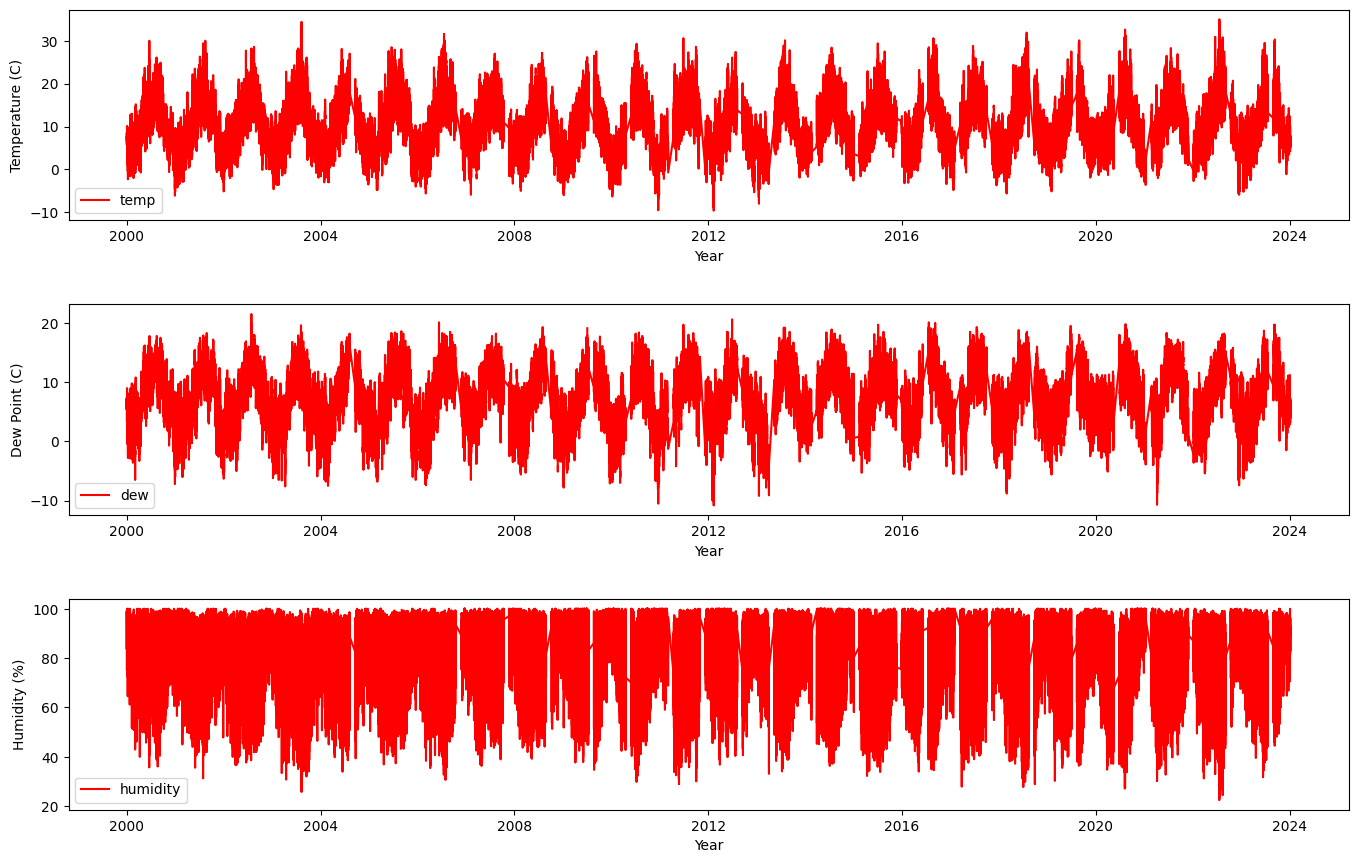

In [656]:
# plot three subplots
plot(col_df,
     ["temp", "dew", "humidity"],
     ["Temperature (C)", "Dew Point (C)", "Humidity (%)"],
     [])

<p>The following 3 figures show how solarradiation, solarenergy and uvindex changes with time, between 2000-2024. Its clearly illustrated that before 29-10-2010 there weren't any reliable readings and most of the slots are empty. Filling these entries would contaminate the dataset instead of helping the model to learn. Hence, I will drop all the rows from the begining till 29-10-2010. Also, the enteries of the solar energy column isn't accurate enough so I will drop it and use the solar radiation as my label instead.</p>

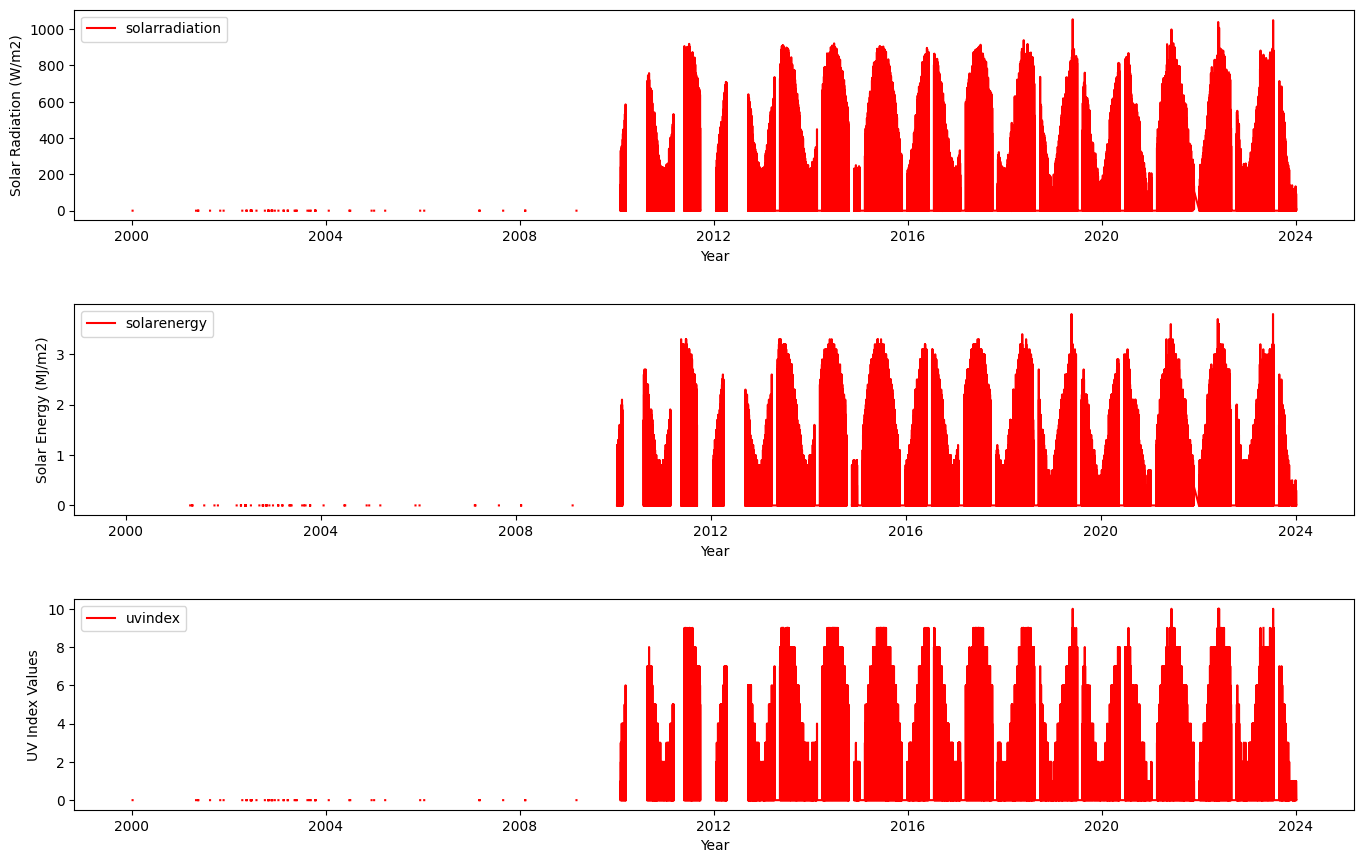

In [657]:
# plot three subplots
plot(col_df,
     ["solarradiation", "solarenergy", "uvindex"],
     ["Solar Radiation (W/m2)", "Solar Energy (MJ/m2)", "UV Index Values"],
     [])

<p>The following 3 figures show how windspeed, winddir and sealevelpressure changes with time, between 2000-2024. This columns will be used only to predict the windspeed. Its obvious that this data is more reliable than the solar related one, therefore no need for dropping any rows.</p>

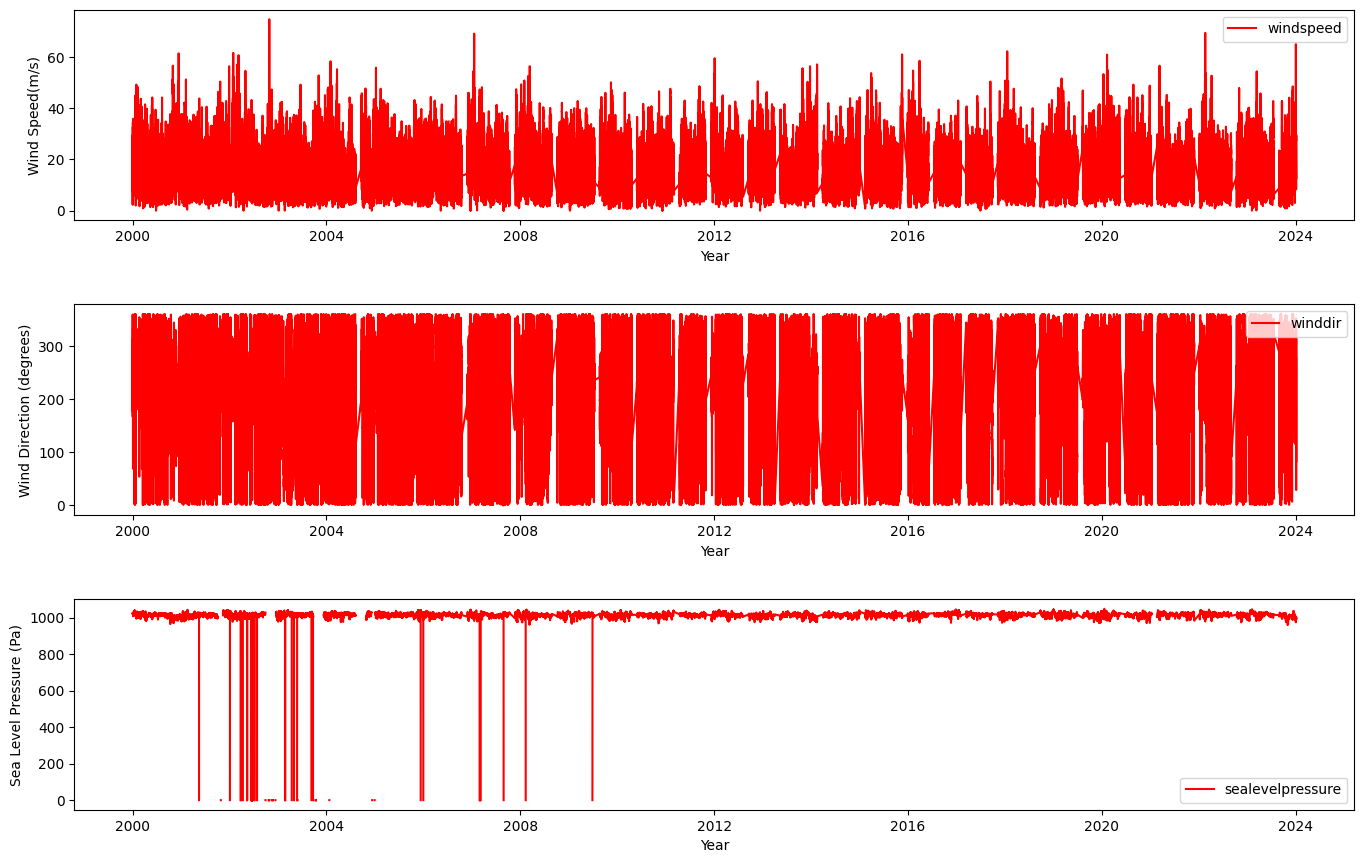

In [658]:
# plot three subplots
plot(col_df,
     ["windspeed", "winddir", "sealevelpressure"],
     ["Wind Speed(m/s)", "Wind Direction (degrees)", "Sea Level Pressure (Pa)"],
     [])

<p>I haven't found any resource on the internet that states that snow, snow depth, or preciptation type might affect the production of solar energy. Despite that almost of the preciptype coloumn are missing, its useless it doesn't make sense to include it in the feature dataset. Hence, I will only use the columns that were defined here FEATURES_COLS_SOLAR.</p>

In [659]:
# check how many missing values per column
col_df.isna().sum()

temp                   418
dew                    424
humidity               422
precip                 587
precipprob             434
preciptype          168576
snow                  1546
snowdepth             1595
windspeed              397
winddir                429
sealevelpressure      7562
cloudcover            3619
solarradiation       93130
solarenergy          93116
uvindex              93127
dtype: int64

In [660]:
# check for duplicated indices
col_df[col_df.index.duplicated(keep=False)].shape

(90, 15)

In [661]:
# drop preciptype column
col_df.drop(["preciptype"], axis=1, inplace=True)
# group duplicated by mean value
col_df = col_df.groupby(col_df.index).mean()
col_df.shape

(187979, 14)

In [662]:
# fill any missing indices - datetime
start_date = pd.to_datetime(col_df.index[0])
end_date = pd.to_datetime(col_df.index[-1])
all_times = pd.date_range(start=start_date, end=end_date, freq="H").floor('H')
col_df = col_df.reindex(all_times)
# apply sine cosine encoding to datetime
encode_datetime(col_df)
col_df

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
2000-01-01 00:00:00   5.9  5.7     98.63     0.0         0.0   NaN        NaN   
2000-01-01 01:00:00   6.4  5.8     96.12     0.0         0.0   NaN        NaN   
2000-01-01 02:00:00   6.6  6.4     98.31     0.0         0.0   NaN        NaN   
2000-01-01 03:00:00   7.2  6.5     95.92     0.0         0.0   NaN        NaN   
2000-01-01 04:00:00   7.2  6.6     96.38     0.0         0.0   NaN        NaN   
...                   ...  ...       ...     ...         ...   ...        ...   
2024-01-05 05:00:00   5.2  4.1     92.17     NaN         0.0   NaN        NaN   
2024-01-05 06:00:00   5.2  4.0     92.40     NaN         0.0   NaN        NaN   
2024-01-05 07:00:00   5.5  4.0     89.64     NaN         0.0   NaN        NaN   
2024-01-05 08:00:00   5.8  4.1     88.93     NaN         0.0   NaN        NaN   
2024-01-05 09:00:00   6.0  4.2     88.83     NaN         0.0   NaN        NaN   

                     windspeed  winddir  sealevelpressure  cloudcover  \
2000-01-01 00:00:00        9.4    210.0            1020.6         NaN   
2000-01-01 01:00:00       15.1    233.0            1020.4       100.0   
2000-01-01 02:00:00       13.9    238.0            1020.5       100.0   
2000-01-01 03:00:00       14.1    232.0            1020.5       100.0   
2000-01-01 04:00:00       14.3    242.0            1020.4       100.0   
...                        ...      ...               ...         ...   
2024-01-05 05:00:00       27.6    325.0             993.2       100.0   
2024-01-05 06:00:00       29.6    317.0             993.5        96.6   
2024-01-05 07:00:00       28.1    308.0             994.5        95.8   
2024-01-05 08:00:00       27.9    313.0             996.1        91.8   
2024-01-05 09:00:00       27.5    311.0             996.9        92.3   

                     solarradiation  solarenergy  uvindex  month_sin  \
2000-01-01 00:00:00             NaN          NaN      NaN        0.5   
2000-01-01 01:00:00             NaN          NaN      NaN        0.5   
2000-01-01 02:00:00             NaN          NaN      NaN        0.5   
2000-01-01 03:00:00             NaN          NaN      NaN        0.5   
2000-01-01 04:00:00             NaN          NaN      NaN        0.5   
...                             ...          ...      ...        ...   
2024-01-05 05:00:00             0.0          0.0      0.0        0.5   
2024-01-05 06:00:00             0.0          0.0      0.0        0.5   
2024-01-05 07:00:00             0.0          0.0      0.0        0.5   
2024-01-05 08:00:00             0.0          0.0      0.0        0.5   
2024-01-05 09:00:00             8.0          0.0      0.0        0.5   

                     month_cos  hour_sin      hour_cos   day_sin   day_cos  
2000-01-01 00:00:00   0.866025  0.000000  1.000000e+00  0.017213  0.999852  
2000-01-01 01:00:00   0.866025  0.258819  9.659258e-01  0.017213  0.999852  
2000-01-01 02:00:00   0.866025  0.500000  8.660254e-01  0.017213  0.999852  
2000-01-01 03:00:00   0.866025  0.707107  7.071068e-01  0.017213  0.999852  
2000-01-01 04:00:00   0.866025  0.866025  5.000000e-01  0.017213  0.999852  
...                        ...       ...           ...       ...       ...  
2024-01-05 05:00:00   0.866025  0.965926  2.588190e-01  0.085965  0.996298  
2024-01-05 06:00:00   0.866025  1.000000  6.123234e-17  0.085965  0.996298  
2024-01-05 07:00:00   0.866025  0.965926 -2.588190e-01  0.085965  0.996298  
2024-01-05 08:00:00   0.866025  0.866025 -5.000000e-01  0.085965  0.996298  
2024-01-05 09:00:00   0.866025  0.707107 -7.071068e-01  0.085965  0.996298  

[210490 rows x 20 columns]

In [663]:
# split dataset into 2 dfs: wind_label and wind_feat
col_wind_label_df, col_wind_feat_df = split_into_wind_solar(col_df)[0:2]

col_wind_label_df.shape, col_wind_feat_df.shape

((210490, 1), (210490, 14))

In [664]:
# split dataset into 2 dfs: solar_label and solar_feat
col_solar_label_df, col_solar_feat_df = split_into_wind_solar(col_df["2010-01-29T00:00:00":])[2:4]

col_solar_label_df.shape, col_solar_feat_df.shape

((122146, 1), (122146, 14))

In [665]:
# split solar dataset into training, validation and testing datasets
solar_dfs = split_raw_datasets(col_solar_label_df, col_solar_feat_df)

train_colchester_solar_df = solar_dfs["train_"]
train_label_colchester_solar_df = solar_dfs["train_label_"]

val_colchester_solar_df = solar_dfs["val_"]
val_label_colchester_solar_df = solar_dfs["val_label_"]

test_colchester_solar_df = solar_dfs["test_"]
test_label_colchester_solar_df = solar_dfs["test_label_"]

# chech on the start and end date of each dataset
print('Start and end of feat training set:\t\t', train_colchester_solar_df.index.min(), train_colchester_solar_df.index.max())
print('Start and end of feat validation set:\t', val_colchester_solar_df.index.min(), val_colchester_solar_df.index.max())
print('Start and end of feat test set:\t\t', test_colchester_solar_df.index.min(), test_colchester_solar_df.index.max())
print('\n')
print('Start and end of label training set:\t\t', train_label_colchester_solar_df.index.min(), train_label_colchester_solar_df.index.max())
print('Start and end of label validation set:\t', val_label_colchester_solar_df.index.min(), val_label_colchester_solar_df.index.max())
print('Start and end of label test set:\t\t', test_label_colchester_solar_df.index.min(), test_label_colchester_solar_df.index.max())

Start and end of feat training set:		 2010-01-29 00:00:00 2021-12-31 23:00:00
Start and end of feat validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of feat test set:		 2023-01-01 00:00:00 2024-01-05 09:00:00


Start and end of label training set:		 2010-01-29 00:00:00 2021-12-31 23:00:00
Start and end of label validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of label test set:		 2023-01-01 00:00:00 2024-01-05 09:00:00


In [666]:
# split wind dataset into training, validation and testing datasets
train_colchester_wind_df = col_wind_feat_df[:'2020']
train_label_colchester_wind_df = col_wind_label_df[:'2020']

val_colchester_wind_df = col_wind_feat_df.loc['2021':'2022']
val_label_colchester_wind_df = col_wind_label_df.loc['2021':'2022']

test_colchester_wind_df = col_wind_feat_df["2023":'2024']
test_label_colchester_wind_df = col_wind_label_df.loc["2023":'2024']

# chech on the start and end date of each dataset
print('Start and end of feat training set:\t\t', train_colchester_wind_df.index.min(), train_colchester_wind_df.index.max())
print('Start and end of feat validation set:\t', val_colchester_wind_df.index.min(), val_colchester_wind_df.index.max())
print('Start and end of feat test set:\t\t', test_colchester_wind_df.index.min(), test_colchester_wind_df.index.max())
print('\n')
print('Start and end of label training set:\t\t', train_label_colchester_wind_df.index.min(), train_label_colchester_wind_df.index.max())
print('Start and end of label validation set:\t', val_label_colchester_wind_df.index.min(), val_label_colchester_wind_df.index.max())
print('Start and end of label test set:\t\t', test_label_colchester_wind_df.index.min(), test_label_colchester_wind_df.index.max())

Start and end of feat training set:		 2000-01-01 00:00:00 2020-12-31 23:00:00
Start and end of feat validation set:	 2021-01-01 00:00:00 2022-12-31 23:00:00
Start and end of feat test set:		 2023-01-01 00:00:00 2024-01-05 09:00:00


Start and end of label training set:		 2000-01-01 00:00:00 2020-12-31 23:00:00
Start and end of label validation set:	 2021-01-01 00:00:00 2022-12-31 23:00:00
Start and end of label test set:		 2023-01-01 00:00:00 2024-01-05 09:00:00


## Impute missing values in solar energy dataset

In [667]:
df_lst = [[train_colchester_solar_df, train_label_colchester_solar_df, "./Data/train_colchester_solar_df.csv"],
         [val_colchester_solar_df, val_label_colchester_solar_df, "./Data/val_colchester_solar_df.csv"],
         [test_colchester_solar_df, test_label_colchester_solar_df, "./Data/test_colchester_solar_df.csv"]]

for i, df in enumerate(df_lst):
    # impute missing values using polynomial interpolation
    df[0] = impute_missing_values(df[0])

    # replace any value for solarradiation during these hours with 0
    # solarradiation can have a value only between 06:00 to 19:00
    df[1].loc[df[1].index.hour < 5,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 20,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 21,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 22,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 23,'solarradiation'] = 0
    
    # impute missing values uisng polynomial interpolation
    
    df[1] = impute_missing_values(df[1])
    
    assert df[0].isna().sum().sum() + df[1].isna().sum().sum() == 0
    
    df[0]['solarradiation'] = df[1]['solarradiation'].copy()

    df[0].to_csv(df[2])

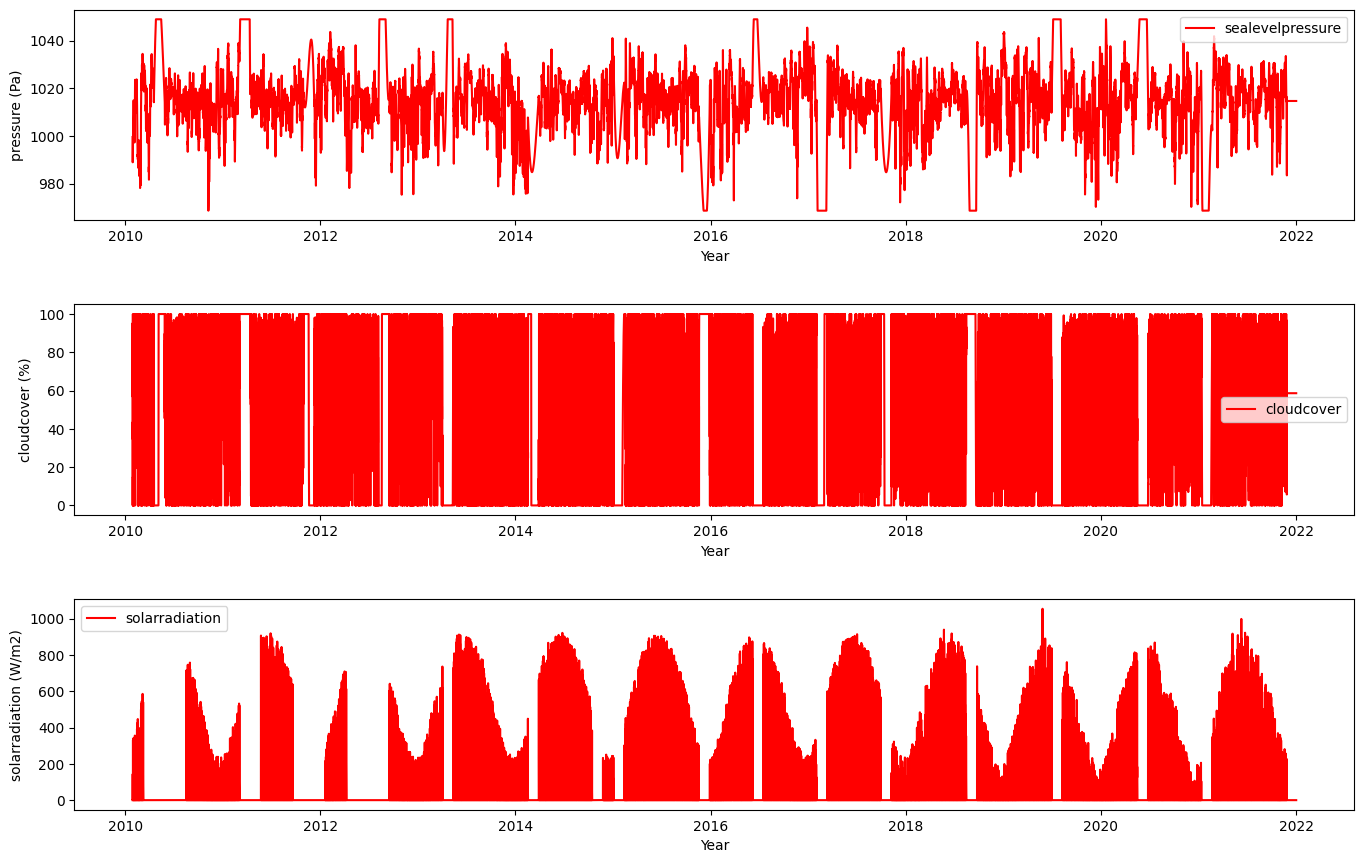

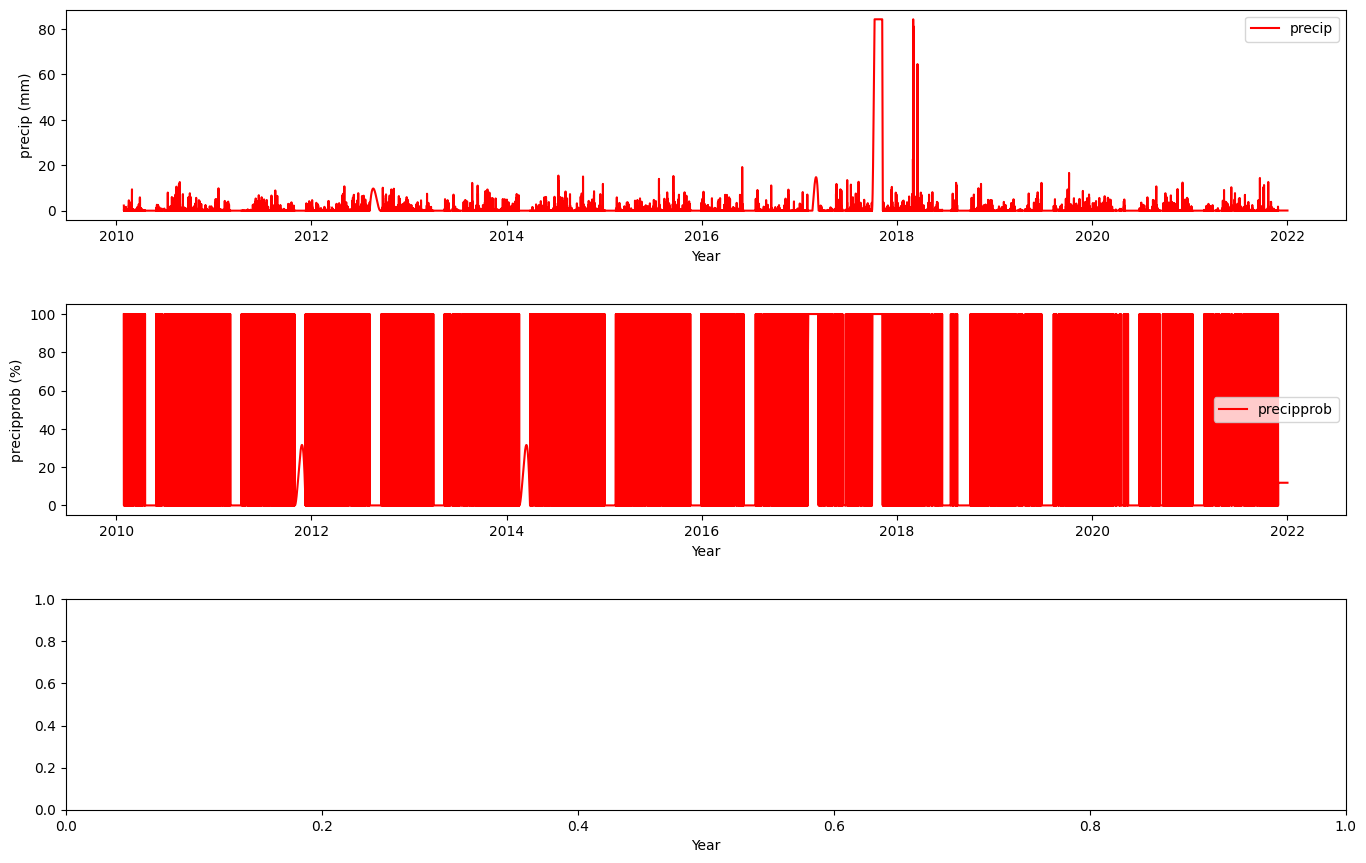

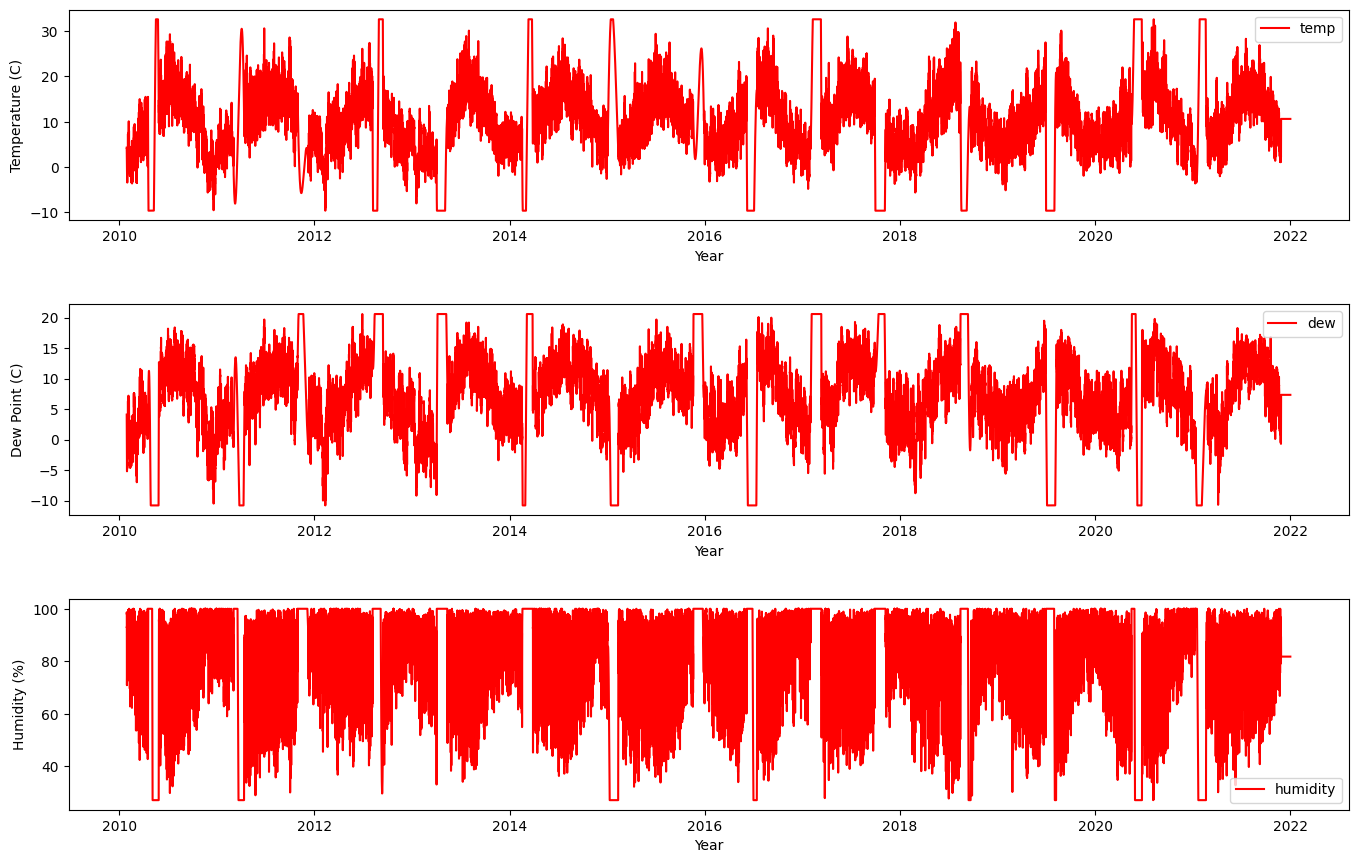

In [668]:
# plot train features and train label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(train_colchester_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(train_colchester_solar_df,
     ["precip", "precipprob", ""],
     ["precip (mm)", "precipprob (%)", ""],
     [])


plot(train_colchester_solar_df,
     ["temp", "dew", "humidity"],
     ["Temperature (C)", "Dew Point (C)", "Humidity (%)"],
     [])

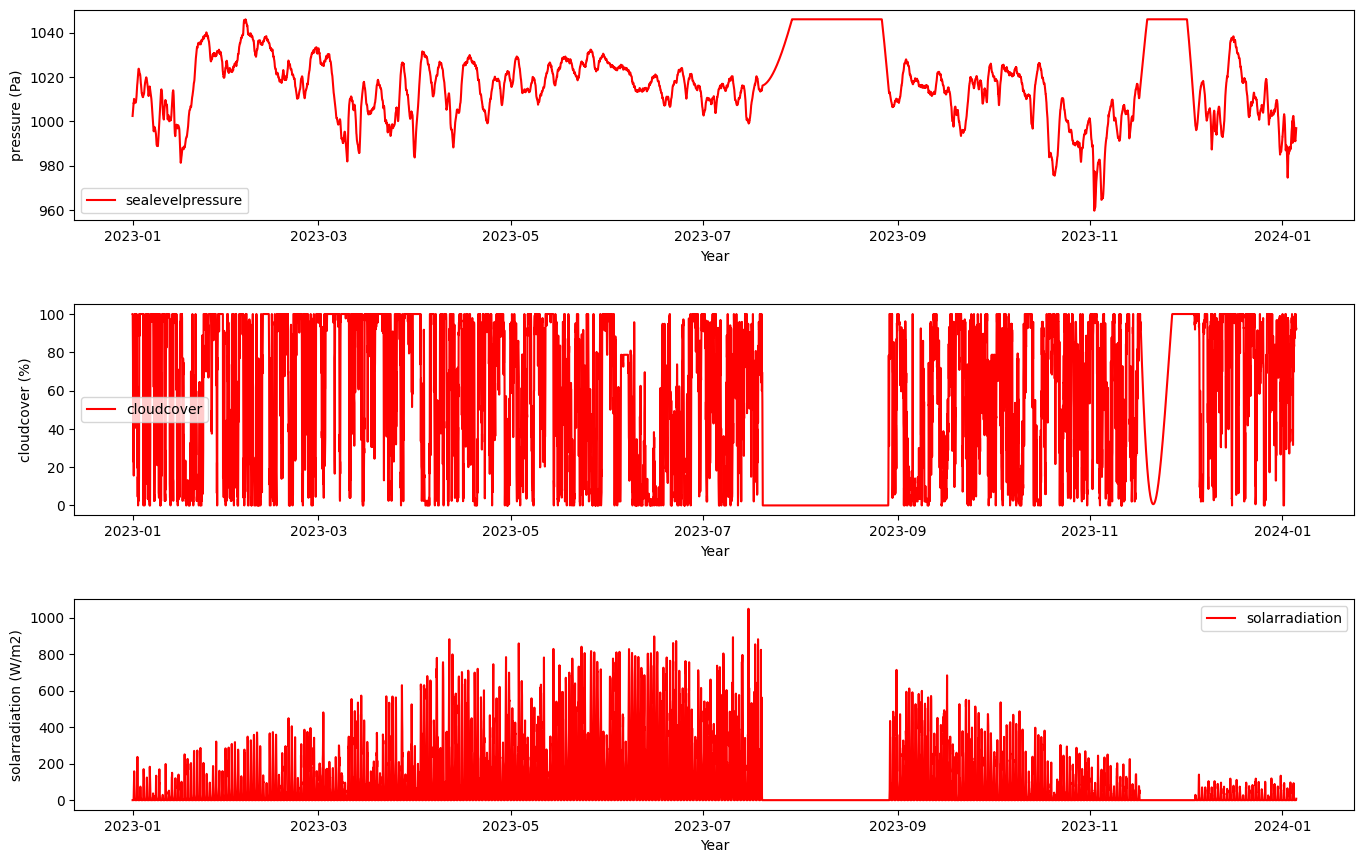

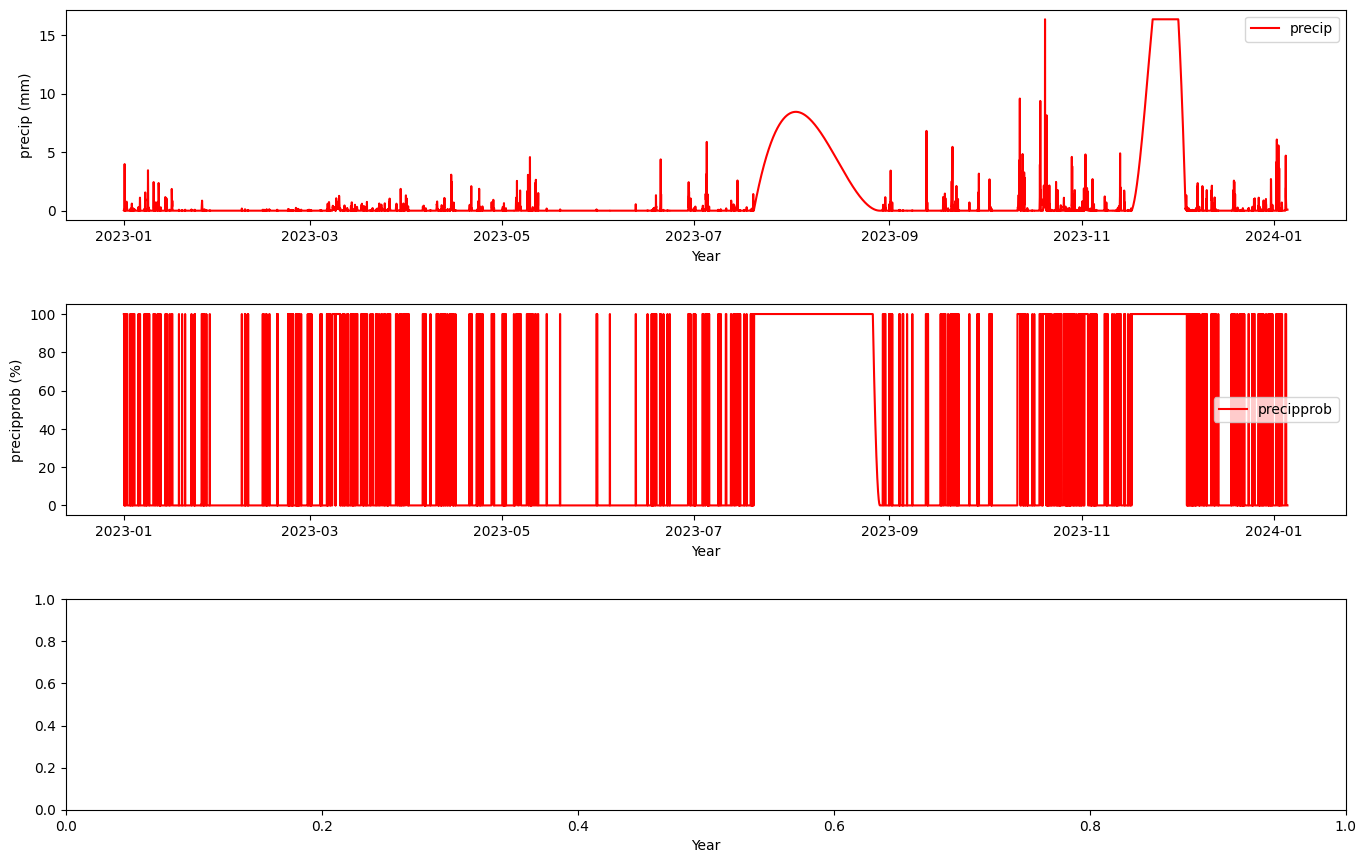

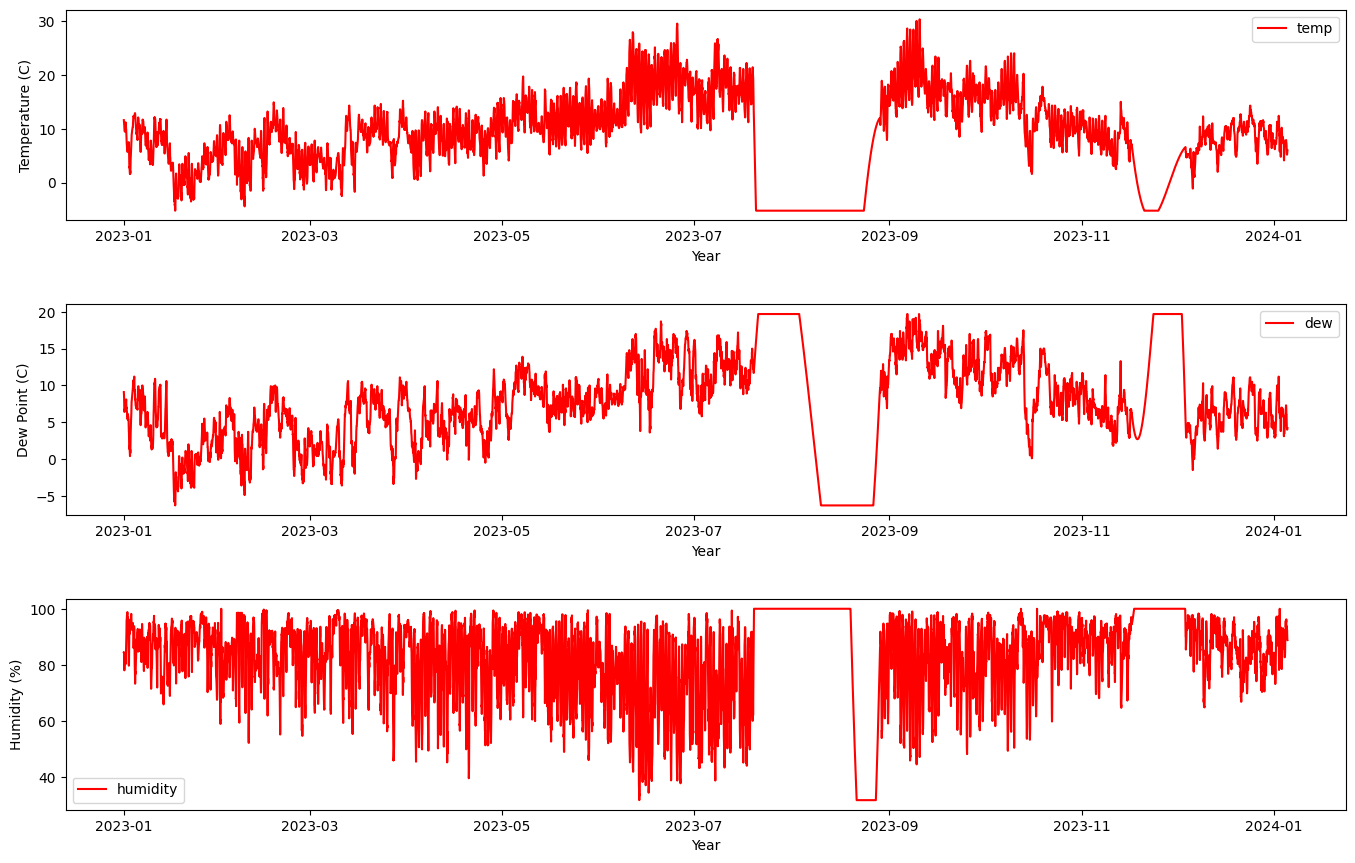

In [669]:
# plot test features and test label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(test_colchester_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(test_colchester_solar_df,
     ["precip", "precipprob", ""],
     ["precip (mm)", "precipprob (%)", ""],
     [])


plot(test_colchester_solar_df,
     ["temp", "dew", "humidity"],
     ["Temperature (C)", "Dew Point (C)", "Humidity (%)"],
     [])

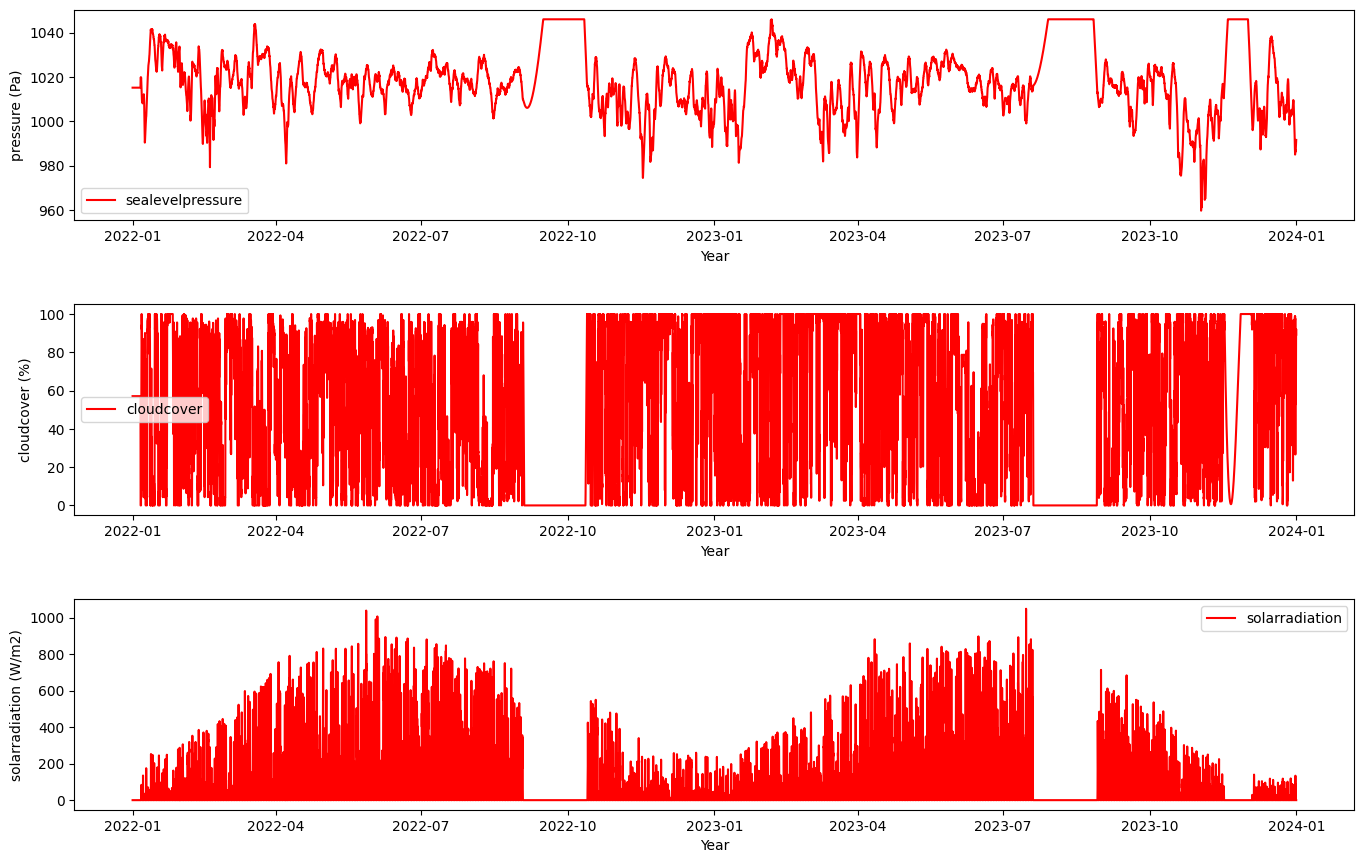

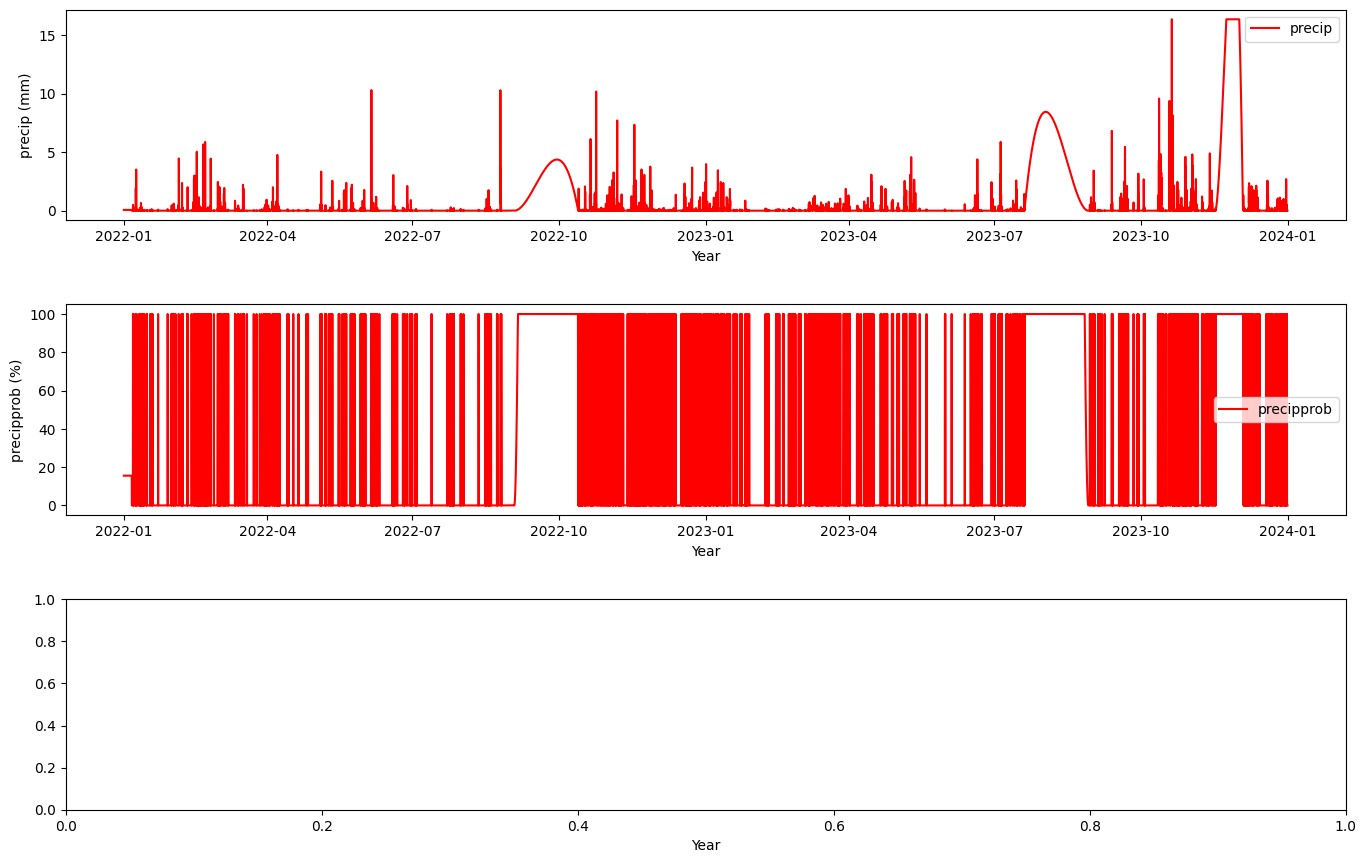

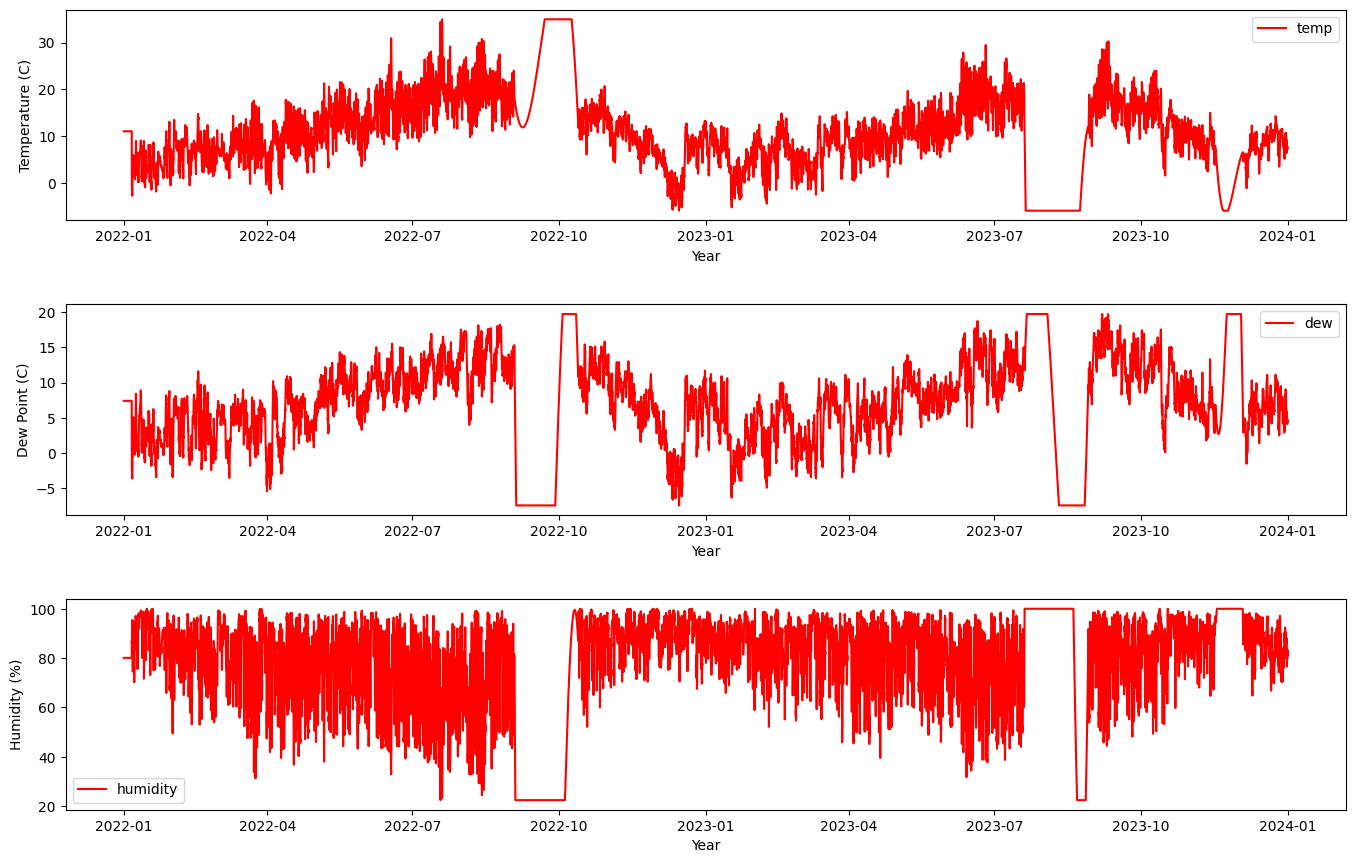

In [670]:
# plot val features and val label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(val_colchester_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(val_colchester_solar_df,
     ["precip", "precipprob", ""],
     ["precip (mm)", "precipprob (%)", ""],
     [])


plot(val_colchester_solar_df,
     ["temp", "dew", "humidity"],
     ["Temperature (C)", "Dew Point (C)", "Humidity (%)"],
     [])

## Impute missing values in wind energy dataset

In [671]:
df_lst = [[train_colchester_wind_df, train_label_colchester_wind_df, "./Data/train_colchester_wind_df.csv"],
         [val_colchester_wind_df, val_label_colchester_wind_df, "./Data/val_colchester_wind_df.csv"],
         [test_colchester_wind_df, test_label_colchester_wind_df, "./Data/test_colchester_wind_df.csv"]]

for i, df in enumerate(df_lst):
    # impute missing values uisng polynomial interpolation
    df[0] = impute_missing_values(df[0])
    df[1] = impute_missing_values(df[1])

    # merge features and label into one dataset

    assert df[0].isna().sum().sum() + df[1].isna().sum().sum(0)== 0

    # Merge label into features data frame
    df[0]['windspeed'] = df[1]['windspeed'].copy()

    df[0].to_csv(df[2])

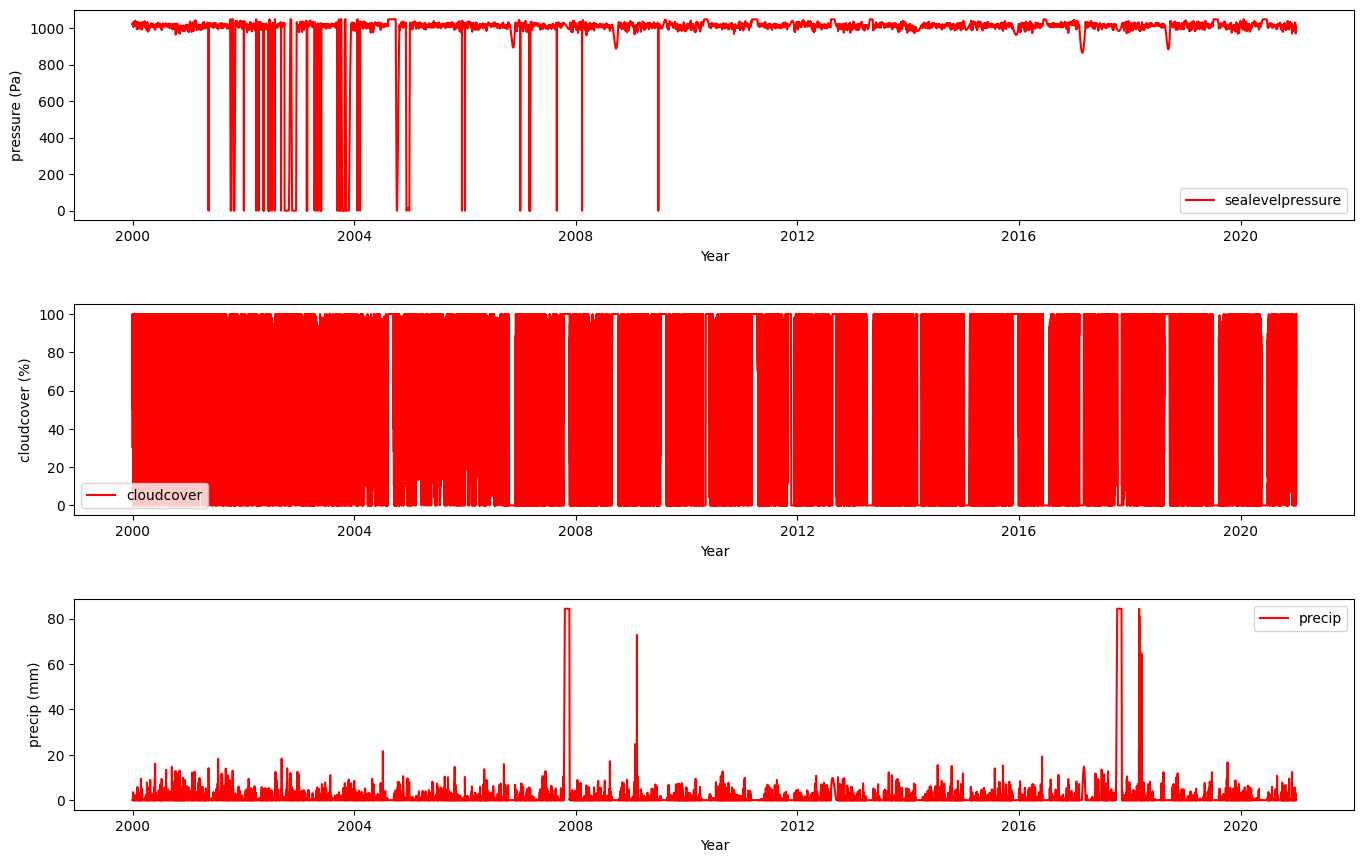

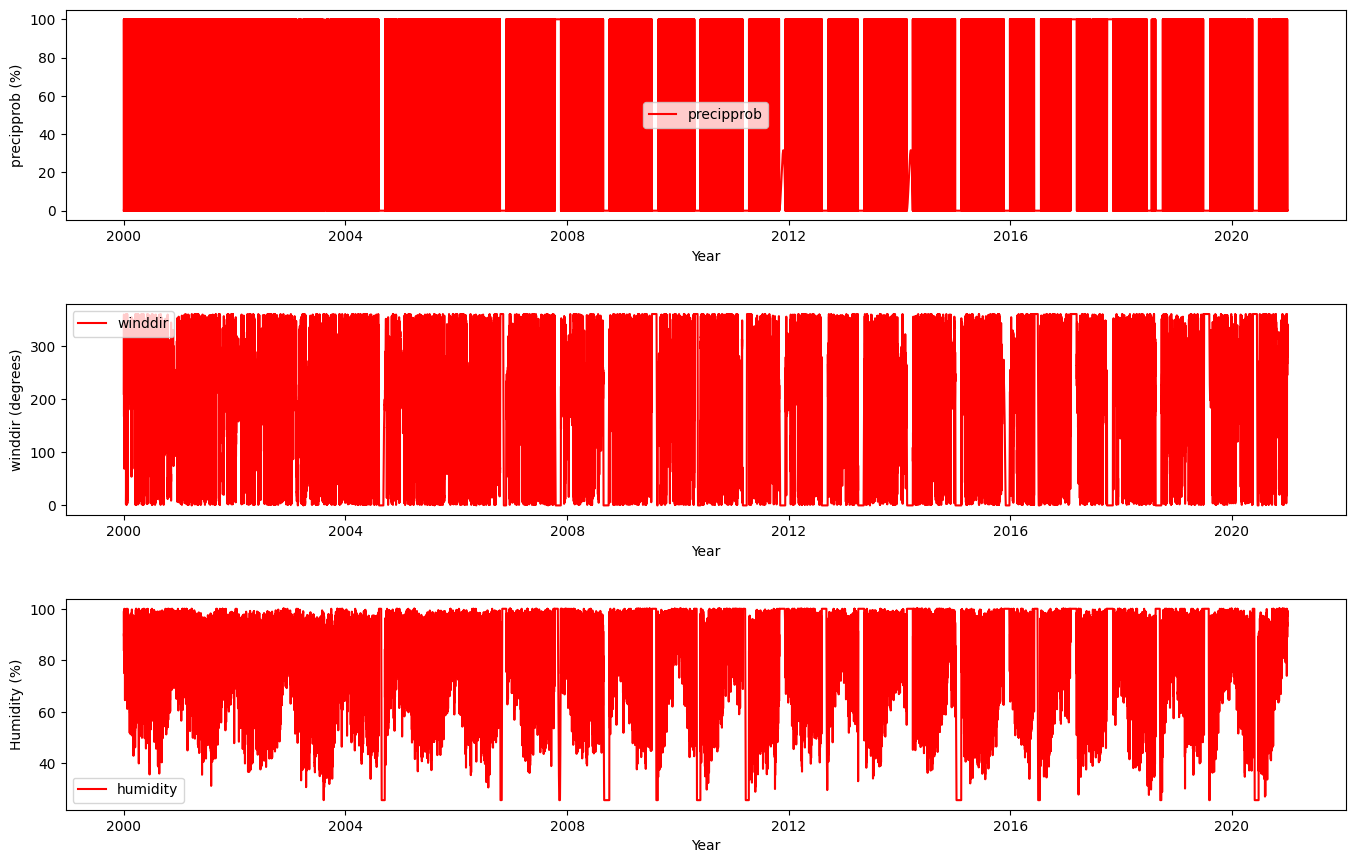

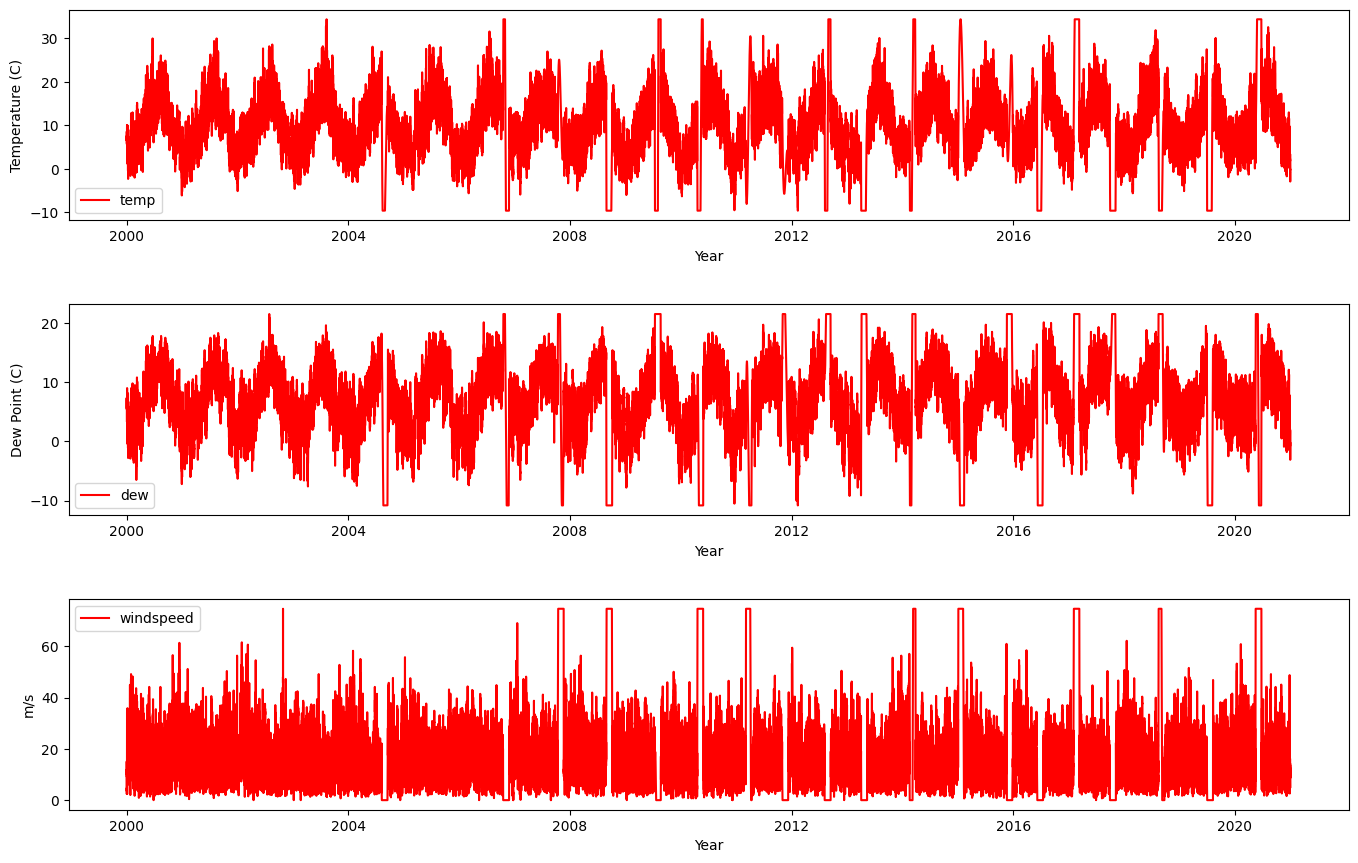

In [672]:
# plot train features and train label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(train_colchester_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])


plot(train_colchester_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])


plot(train_colchester_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s"],
     [])

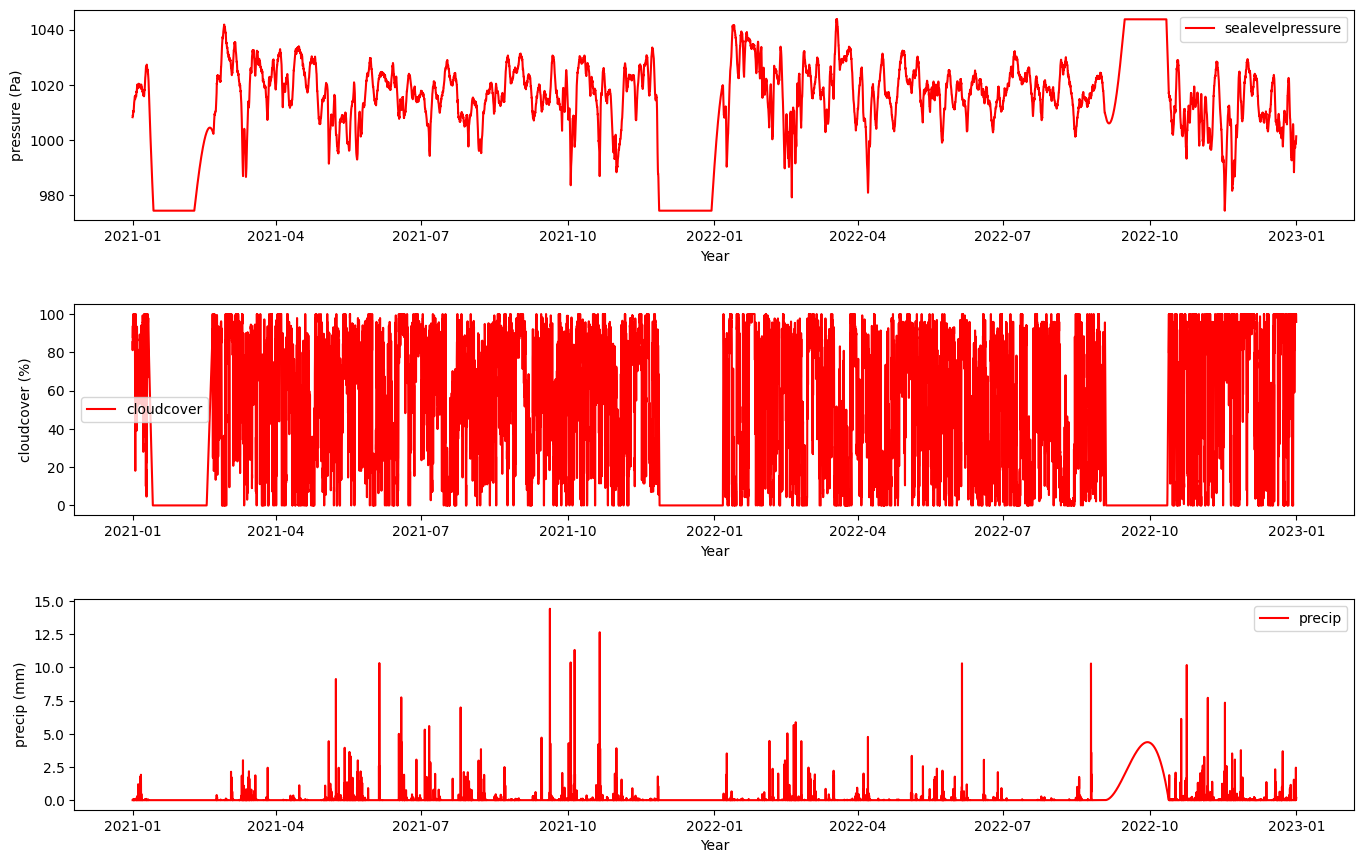

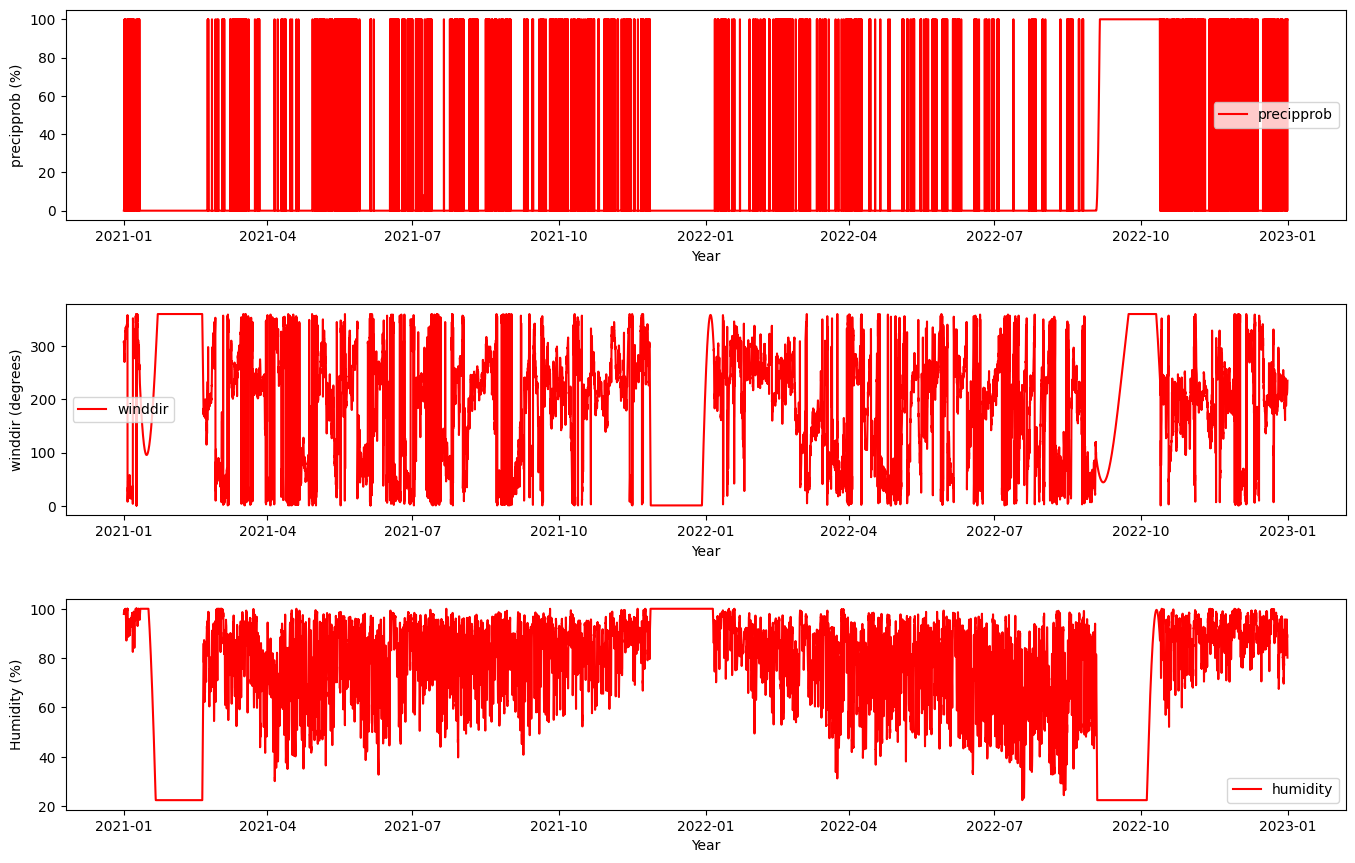

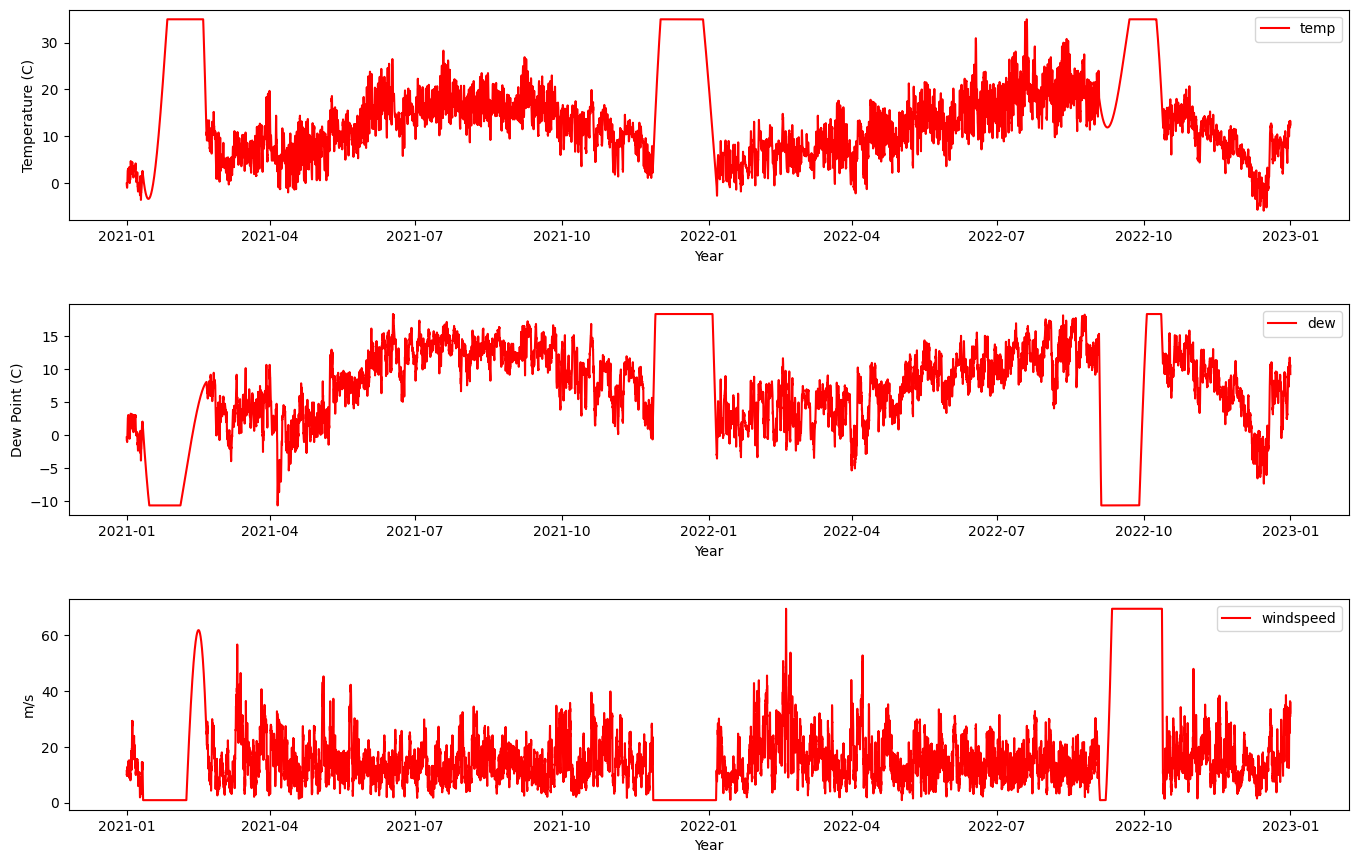

In [673]:
# plot val features and val label after preprocessing - cleaning, imputation, removing duplicates etc.

plot(val_colchester_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])


plot(val_colchester_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])


plot(val_colchester_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s"],
     [])

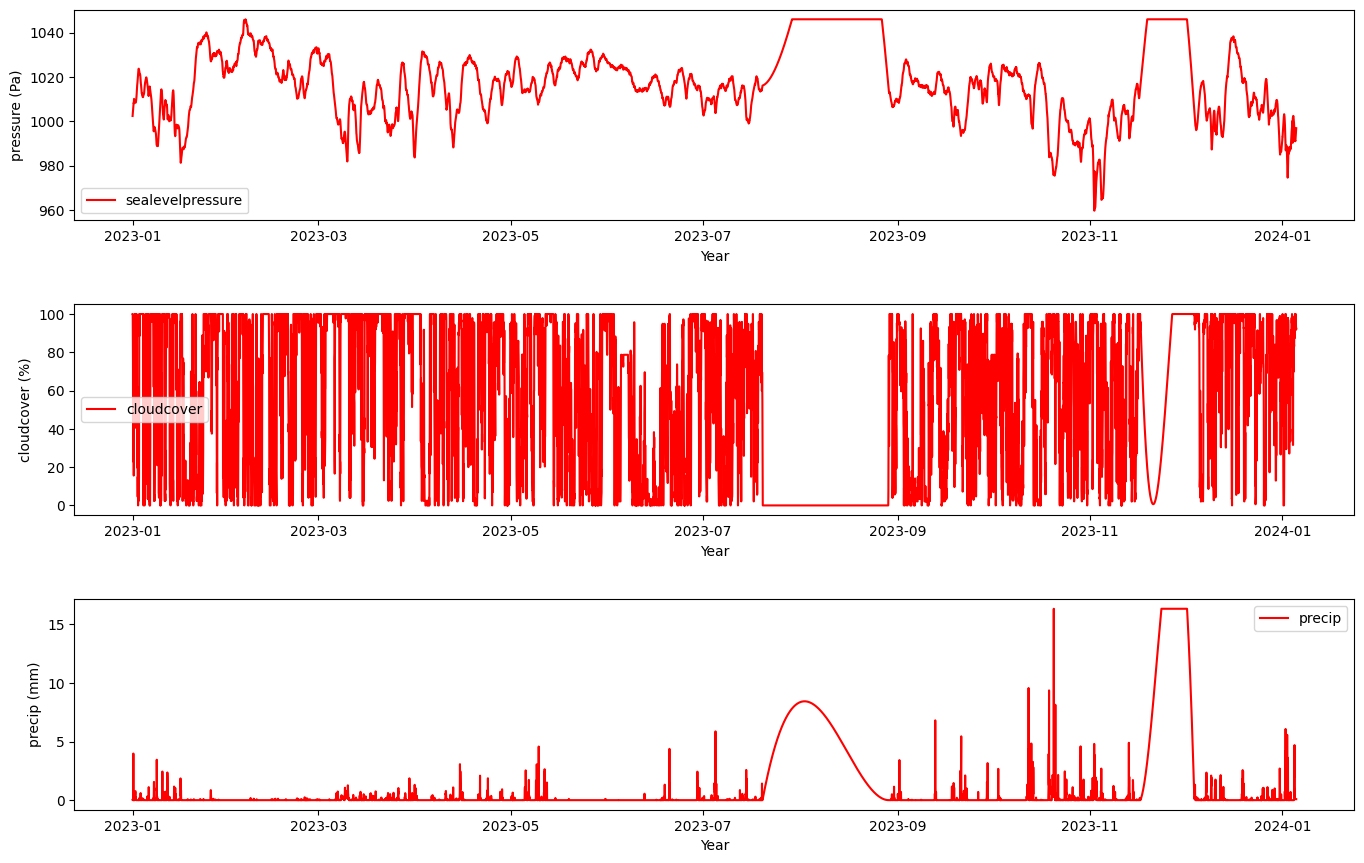

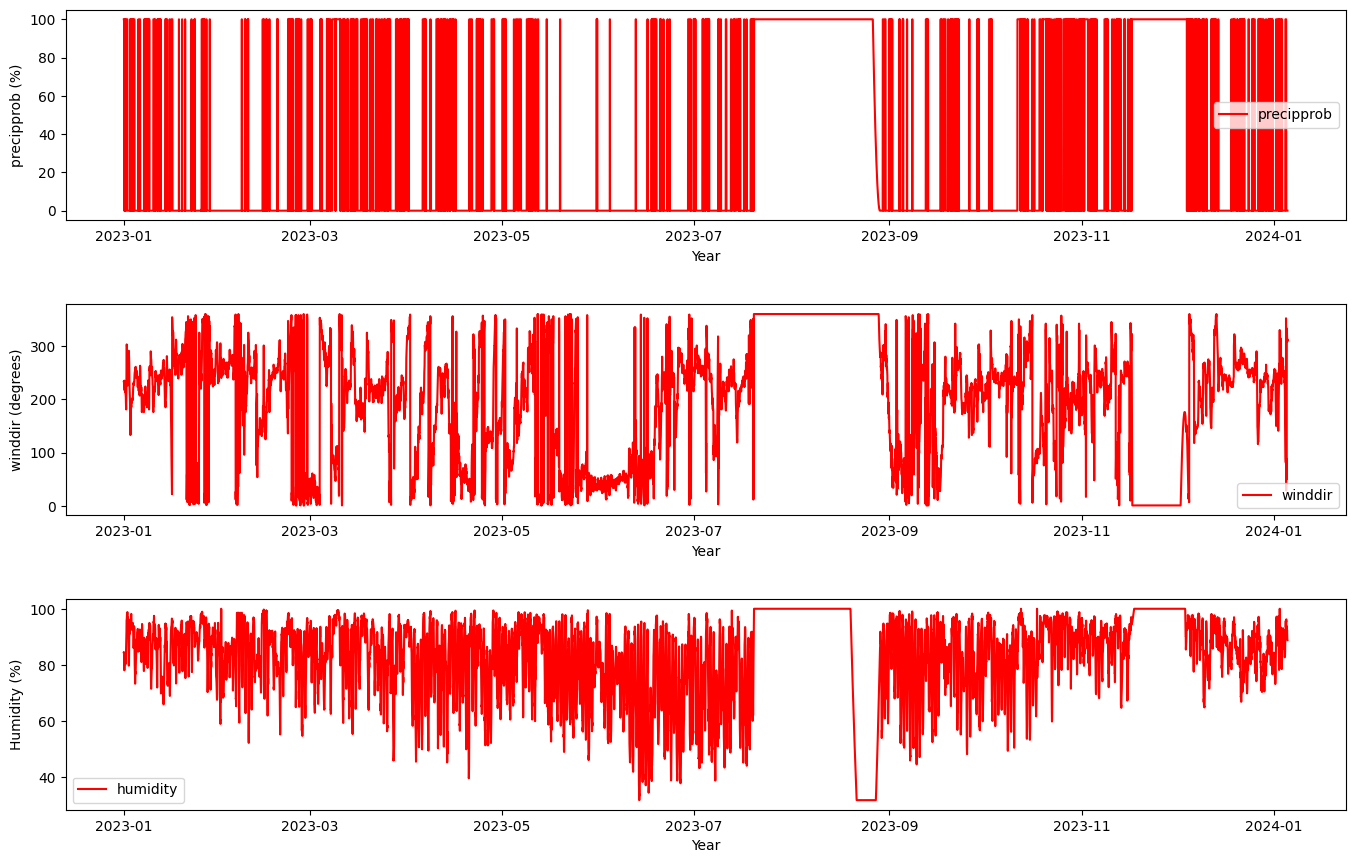

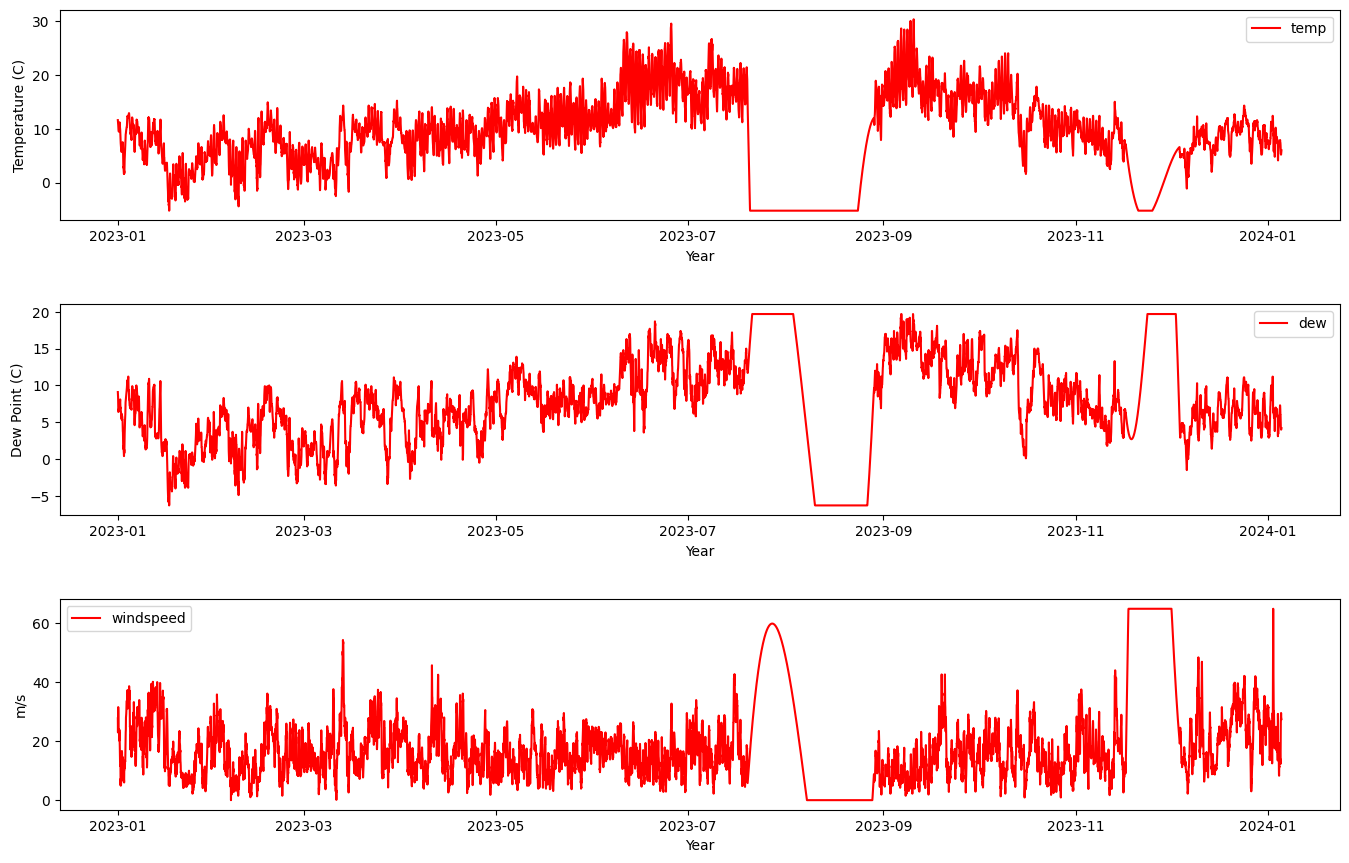

In [674]:
# plot test features and test label after preprocessing - cleaning, imputation, removing duplicates etc.

plot(test_colchester_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])


plot(test_colchester_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])


plot(test_colchester_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s"],
     [])

<h1 style="text-align: center;">Brighton dataset</h1>

In [675]:
# read and merge multiple csv files into one dataframe
britn_df = create_df_from_multiple_csvs(BRIGHTON_DATA_DIR, "./Data/BrightonRawData.csv")
# set datetime as index using the ISO date format
britn_df['datetime'] = pd.to_datetime(britn_df['datetime'], format='%Y-%m-%dT%H:%M:%S')
britn_df.set_index("datetime", inplace = True)
britn_df

temp  dew  humidity  precip  precipprob preciptype  snow  \
datetime                                                                        
2010-01-01 00:00:00   1.9 -0.5     84.25   0.417       100.0  rain,snow   0.0   
2010-01-01 01:00:00   1.9 -0.5     83.90   0.000         0.0        NaN   0.0   
2010-01-01 02:00:00   1.4 -0.7     85.76   0.000         0.0        NaN   0.0   
2010-01-01 03:00:00   1.4 -0.7     85.69   0.000         0.0        NaN   0.0   
2010-01-01 04:00:00   1.3 -0.8     85.72   0.000         0.0        NaN   0.0   
...                   ...  ...       ...     ...         ...        ...   ...   
2024-01-06 07:00:00   5.1  3.5     89.07     NaN         0.0        NaN   NaN   
2024-01-06 08:00:00   5.0  3.5     90.24     NaN         0.0        NaN   NaN   
2024-01-06 09:00:00   4.9  3.9     92.89     NaN         0.0        NaN   NaN   
2024-01-06 10:00:00   5.9  4.8     92.47     NaN         0.0        NaN   NaN   
2024-01-06 11:00:00   6.8  4.8     86.98     NaN         0.0        NaN   NaN   

                     snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                               
2010-01-01 00:00:00        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00        0.0       17.4     10.0            1000.5   
...                        ...        ...      ...               ...   
2024-01-06 07:00:00        NaN        9.6    327.0            1013.2   
2024-01-06 08:00:00        NaN        8.9    320.0            1014.0   
2024-01-06 09:00:00        NaN        9.6    321.0            1015.0   
2024-01-06 10:00:00        NaN        7.8    340.0            1016.0   
2024-01-06 11:00:00        NaN       16.0    349.0            1016.0   

                     cloudcover  solarradiation  solarenergy  uvindex  
datetime                                                               
2010-01-01 00:00:00        62.2             0.0          0.0      0.0  
2010-01-01 01:00:00        22.4             0.0          0.0      0.0  
2010-01-01 02:00:00        38.0             0.0          0.0      0.0  
2010-01-01 03:00:00        66.7             0.0          0.0      0.0  
2010-01-01 04:00:00        62.8             0.0          0.0      0.0  
...                         ...             ...          ...      ...  
2024-01-06 07:00:00        65.1             0.0          0.0      0.0  
2024-01-06 08:00:00        89.9             0.0          0.0      0.0  
2024-01-06 09:00:00        85.5            23.0          0.1      0.0  
2024-01-06 10:00:00        51.7            72.0          0.3      1.0  
2024-01-06 11:00:00        29.5           178.0          0.6      2.0  

[122844 rows x 15 columns]

## Visuallising data

<p>The following 3 figures show how temp, dew and humidity changes with time, between 2000-2024. All the figures illustrate seasonality and trend for all features.</p>

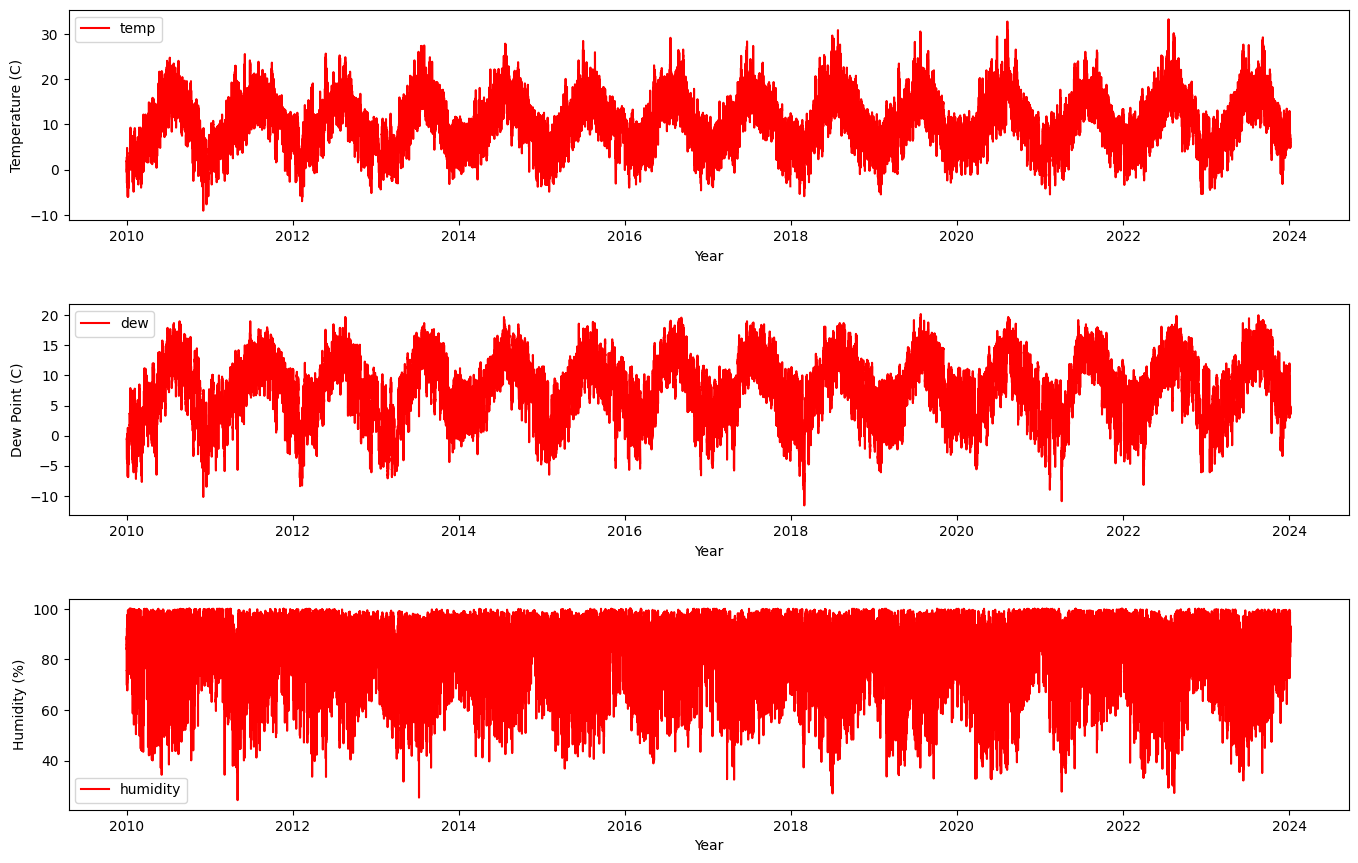

In [676]:
# plot three subplots
plot(britn_df,
     ["temp", "dew", "humidity"],
     ["Temperature (C)", "Dew Point (C)", "Humidity (%)"],
     [])

<p>The following 3 figures show how solarradiation, solarenergy and uvindex changes with time, between 2000-2024. Its clearly illustrated that the data are somehow semetric and normally distributed.</p>

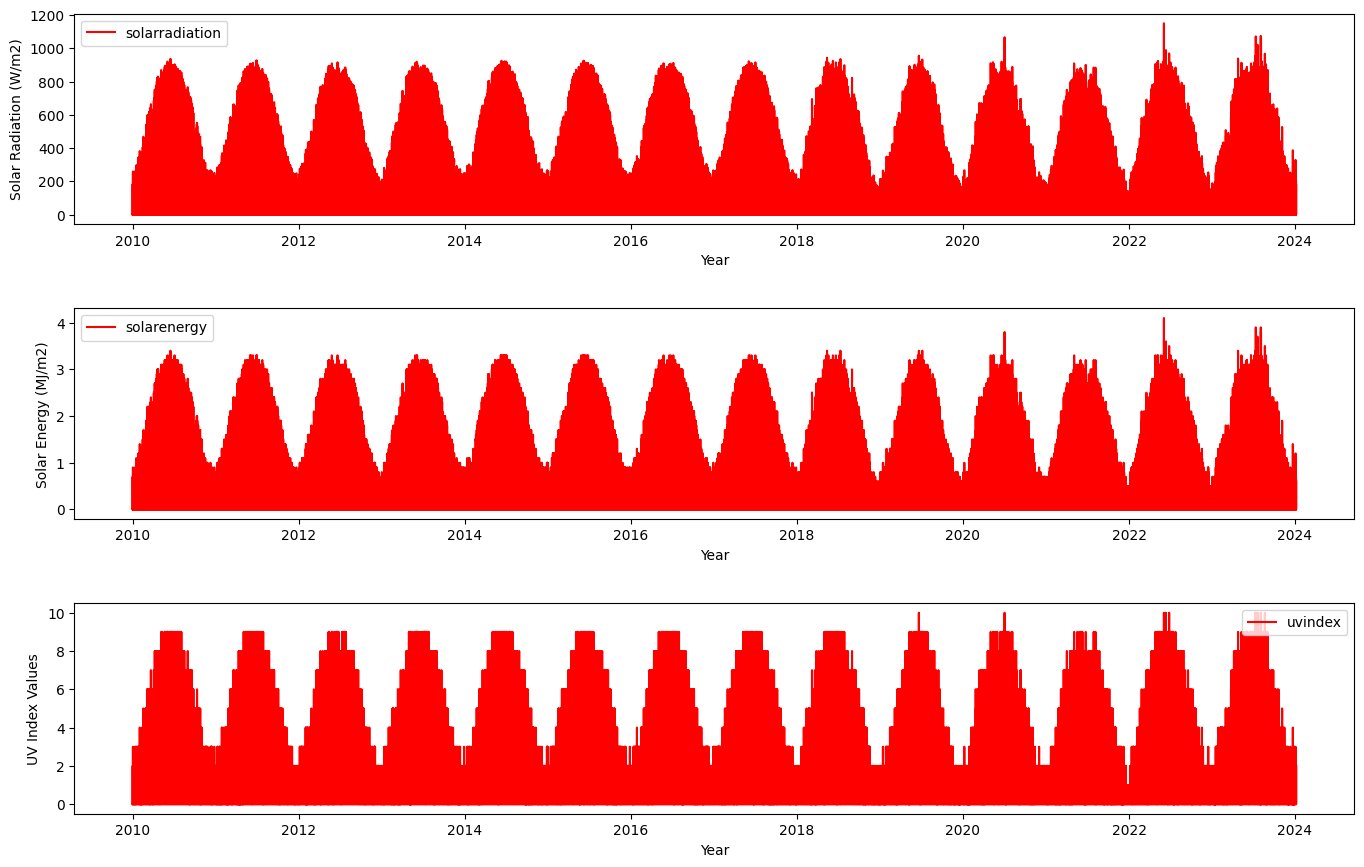

In [677]:
# plot three subplots
plot(britn_df,
     ["solarradiation", "solarenergy", "uvindex"],
     ["Solar Radiation (W/m2)", "Solar Energy (MJ/m2)", "UV Index Values"],
     [])

<p>The following 3 figures show how windspeed, winddir and sealevelpressure changes with time, between 2000-2024.</p>

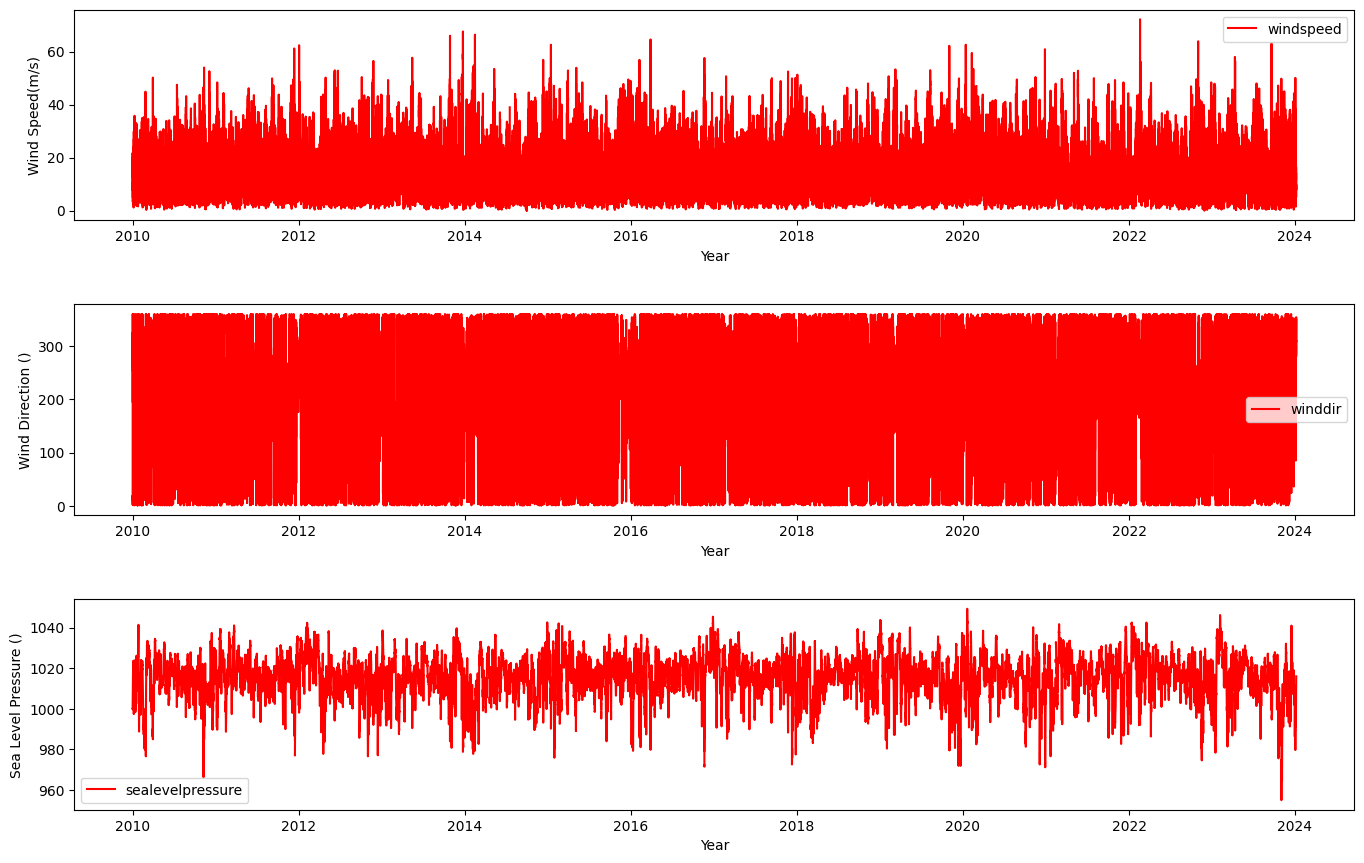

In [678]:
# plot three subplots
plot(britn_df,
     ["windspeed", "winddir", "sealevelpressure"],
     ["Wind Speed(m/s)", "Wind Direction ()", "Sea Level Pressure ()"],
     [])

<p>None of the  states that snow, snow depth, or preciptation type might affect the production of wind energy. Despite that almost of the preciptype coloumn are missing, its useless it doesn't make sense to include it in the feature dataset. Hence, I will only use the columns that were defined here FEATURES_COLS_WIND.</p>

In [679]:
# check how many missing values per column
britn_df.isna().sum()

temp                   254
dew                    276
humidity               269
precip                 279
precipprob             286
preciptype          111567
snow                 33034
snowdepth            33565
windspeed              261
winddir                277
sealevelpressure       525
cloudcover             288
solarradiation         330
solarenergy            364
uvindex                358
dtype: int64

In [680]:
# check for duplicated indices
britn_df[britn_df.index.duplicated(keep=False)].shape

(28, 15)

In [681]:
# drop preciptype column
britn_df.drop(["preciptype"], axis=1, inplace=True)
# group duplicated by mean value
britn_df = britn_df.groupby(britn_df.index).mean()
britn_df.shape

(122830, 14)

In [682]:
# fill any missing indices - datetime
start_date = pd.to_datetime(britn_df.index[0])
end_date = pd.to_datetime(britn_df.index[-1])
all_times = pd.date_range(start=start_date, end=end_date, freq="H").floor('H')
britn_df = britn_df.reindex(all_times)
# apply sine cosine encoding to datetime
encode_datetime(britn_df)
britn_df

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
2010-01-01 00:00:00   1.9 -0.5     84.25   0.417       100.0   0.0        0.0   
2010-01-01 01:00:00   1.9 -0.5     83.90   0.000         0.0   0.0        0.0   
2010-01-01 02:00:00   1.4 -0.7     85.76   0.000         0.0   0.0        0.0   
2010-01-01 03:00:00   1.4 -0.7     85.69   0.000         0.0   0.0        0.0   
2010-01-01 04:00:00   1.3 -0.8     85.72   0.000         0.0   0.0        0.0   
...                   ...  ...       ...     ...         ...   ...        ...   
2024-01-06 07:00:00   5.1  3.5     89.07     NaN         0.0   NaN        NaN   
2024-01-06 08:00:00   5.0  3.5     90.24     NaN         0.0   NaN        NaN   
2024-01-06 09:00:00   4.9  3.9     92.89     NaN         0.0   NaN        NaN   
2024-01-06 10:00:00   5.9  4.8     92.47     NaN         0.0   NaN        NaN   
2024-01-06 11:00:00   6.8  4.8     86.98     NaN         0.0   NaN        NaN   

                     windspeed  winddir  sealevelpressure  cloudcover  \
2010-01-01 00:00:00       19.4     11.0             999.9        62.2   
2010-01-01 01:00:00       21.8     19.0             999.8        22.4   
2010-01-01 02:00:00       17.7     10.0            1000.0        38.0   
2010-01-01 03:00:00       18.0     11.0            1000.2        66.7   
2010-01-01 04:00:00       17.4     10.0            1000.5        62.8   
...                        ...      ...               ...         ...   
2024-01-06 07:00:00        9.6    327.0            1013.2        65.1   
2024-01-06 08:00:00        8.9    320.0            1014.0        89.9   
2024-01-06 09:00:00        9.6    321.0            1015.0        85.5   
2024-01-06 10:00:00        7.8    340.0            1016.0        51.7   
2024-01-06 11:00:00       16.0    349.0            1016.0        29.5   

                     solarradiation  solarenergy  uvindex  month_sin  \
2010-01-01 00:00:00             0.0          0.0      0.0        0.5   
2010-01-01 01:00:00             0.0          0.0      0.0        0.5   
2010-01-01 02:00:00             0.0          0.0      0.0        0.5   
2010-01-01 03:00:00             0.0          0.0      0.0        0.5   
2010-01-01 04:00:00             0.0          0.0      0.0        0.5   
...                             ...          ...      ...        ...   
2024-01-06 07:00:00             0.0          0.0      0.0        0.5   
2024-01-06 08:00:00             0.0          0.0      0.0        0.5   
2024-01-06 09:00:00            23.0          0.1      0.0        0.5   
2024-01-06 10:00:00            72.0          0.3      1.0        0.5   
2024-01-06 11:00:00           178.0          0.6      2.0        0.5   

                     month_cos  hour_sin  hour_cos   day_sin   day_cos  
2010-01-01 00:00:00   0.866025  0.000000  1.000000  0.017213  0.999852  
2010-01-01 01:00:00   0.866025  0.258819  0.965926  0.017213  0.999852  
2010-01-01 02:00:00   0.866025  0.500000  0.866025  0.017213  0.999852  
2010-01-01 03:00:00   0.866025  0.707107  0.707107  0.017213  0.999852  
2010-01-01 04:00:00   0.866025  0.866025  0.500000  0.017213  0.999852  
...                        ...       ...       ...       ...       ...  
2024-01-06 07:00:00   0.866025  0.965926 -0.258819  0.103102  0.994671  
2024-01-06 08:00:00   0.866025  0.866025 -0.500000  0.103102  0.994671  
2024-01-06 09:00:00   0.866025  0.707107 -0.707107  0.103102  0.994671  
2024-01-06 10:00:00   0.866025  0.500000 -0.866025  0.103102  0.994671  
2024-01-06 11:00:00   0.866025  0.258819 -0.965926  0.103102  0.994671  

[122844 rows x 20 columns]

In [683]:
# split dataset into 4 df - wind_label, wind_feat, solar_label and solar_feat
briton_wind_label_df, briton_wind_feat_df, briton_solar_label_df, briton_solar_feat_df = split_into_wind_solar(britn_df)
briton_wind_label_df.shape, briton_wind_feat_df.shape, briton_solar_label_df.shape, briton_solar_feat_df.shape

((122844, 1), (122844, 14), (122844, 1), (122844, 14))

In [684]:
# split wind energy raw databases into training, validation and testing
wind_dfs = split_raw_datasets(briton_wind_label_df, briton_wind_feat_df)

train_brighton_wind_df = wind_dfs["train_"]
train_label_brighton_wind_df = wind_dfs["train_label_"]

val_brighton_wind_df = wind_dfs["val_"]
val_label_brighton_wind_df = wind_dfs["val_label_"]

test_brighton_wind_df = wind_dfs["test_"]
test_label_brighton_wind_df = wind_dfs["test_label_"]

# chech on the start and end date of each dataset
print('Start and end of feat training set:\t\t', train_brighton_wind_df.index.min(), train_brighton_wind_df.index.max())
print('Start and end of feat validation set:\t', val_brighton_wind_df.index.min(), val_brighton_wind_df.index.max())
print('Start and end of feat test set:\t\t', test_brighton_wind_df.index.min(), test_brighton_wind_df.index.max())
print('\n')
print('Start and end of label training set:\t\t', train_label_brighton_wind_df.index.min(), train_label_brighton_wind_df.index.max())
print('Start and end of label validation set:\t', val_label_brighton_wind_df.index.min(), val_label_brighton_wind_df.index.max())
print('Start and end of label test set:\t\t', test_label_brighton_wind_df.index.min(), test_label_brighton_wind_df.index.max())

Start and end of feat training set:		 2010-01-01 00:00:00 2021-12-31 23:00:00
Start and end of feat validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of feat test set:		 2023-01-01 00:00:00 2024-01-06 11:00:00


Start and end of label training set:		 2010-01-01 00:00:00 2021-12-31 23:00:00
Start and end of label validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of label test set:		 2023-01-01 00:00:00 2024-01-06 11:00:00


In [685]:
# split solar energy raw databases into training, validation and testing
solar_dfs = split_raw_datasets(briton_solar_label_df, briton_solar_feat_df)

train_brighton_solar_df = solar_dfs["train_"]
train_label_brighton_solar_df = solar_dfs["train_label_"]

val_brighton_solar_df = solar_dfs["val_"]
val_label_brighton_solar_df = solar_dfs["val_label_"]

test_brighton_solar_df = solar_dfs["test_"]
test_label_brighton_solar_df = solar_dfs["test_label_"]

# check on the start and end date of each dataset
print('Start and end of feat training set:\t\t', train_brighton_solar_df.index.min(), train_brighton_solar_df.index.max())
print('Start and end of feat validation set:\t', val_brighton_solar_df.index.min(), val_brighton_solar_df.index.max())
print('Start and end of feat test set:\t\t', test_brighton_solar_df.index.min(), test_brighton_solar_df.index.max())
print('\n')
print('Start and end of label training set:\t\t', train_label_brighton_solar_df.index.min(), train_label_brighton_solar_df.index.max())
print('Start and end of label validation set:\t', val_label_brighton_solar_df.index.min(), val_label_brighton_solar_df.index.max())
print('Start and end of label test set:\t\t', test_label_brighton_solar_df.index.min(), test_label_brighton_solar_df.index.max())

Start and end of feat training set:		 2010-01-01 00:00:00 2021-12-31 23:00:00
Start and end of feat validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of feat test set:		 2023-01-01 00:00:00 2024-01-06 11:00:00


Start and end of label training set:		 2010-01-01 00:00:00 2021-12-31 23:00:00
Start and end of label validation set:	 2022-01-01 00:00:00 2023-12-31 23:00:00
Start and end of label test set:		 2023-01-01 00:00:00 2024-01-06 11:00:00


## Impute missing values in wind energy dataset

In [686]:
df_lst = [[test_brighton_wind_df, test_label_brighton_wind_df, "./Data/test_brighton_wind_df.csv"],
         [val_brighton_wind_df, val_label_brighton_wind_df, "./Data/val_brighton_wind_df.csv"],
         [train_brighton_wind_df, train_label_brighton_wind_df, "./Data/train_brighton_wind_df.csv"]]

for df in df_lst:
    # impute missing values uisng polynomial interpolation
    df[0] = impute_missing_values(df[0])
    df[1] = impute_missing_values(df[1])

    # Assert that no empty values 
    assert df[0].isna().sum().sum() + df[1].isna().sum().sum(0)== 0

    # Merge label into features data frame
    df[0]['windspeed'] = df[1]['windspeed'].copy()

    df[0].to_csv(df[2])

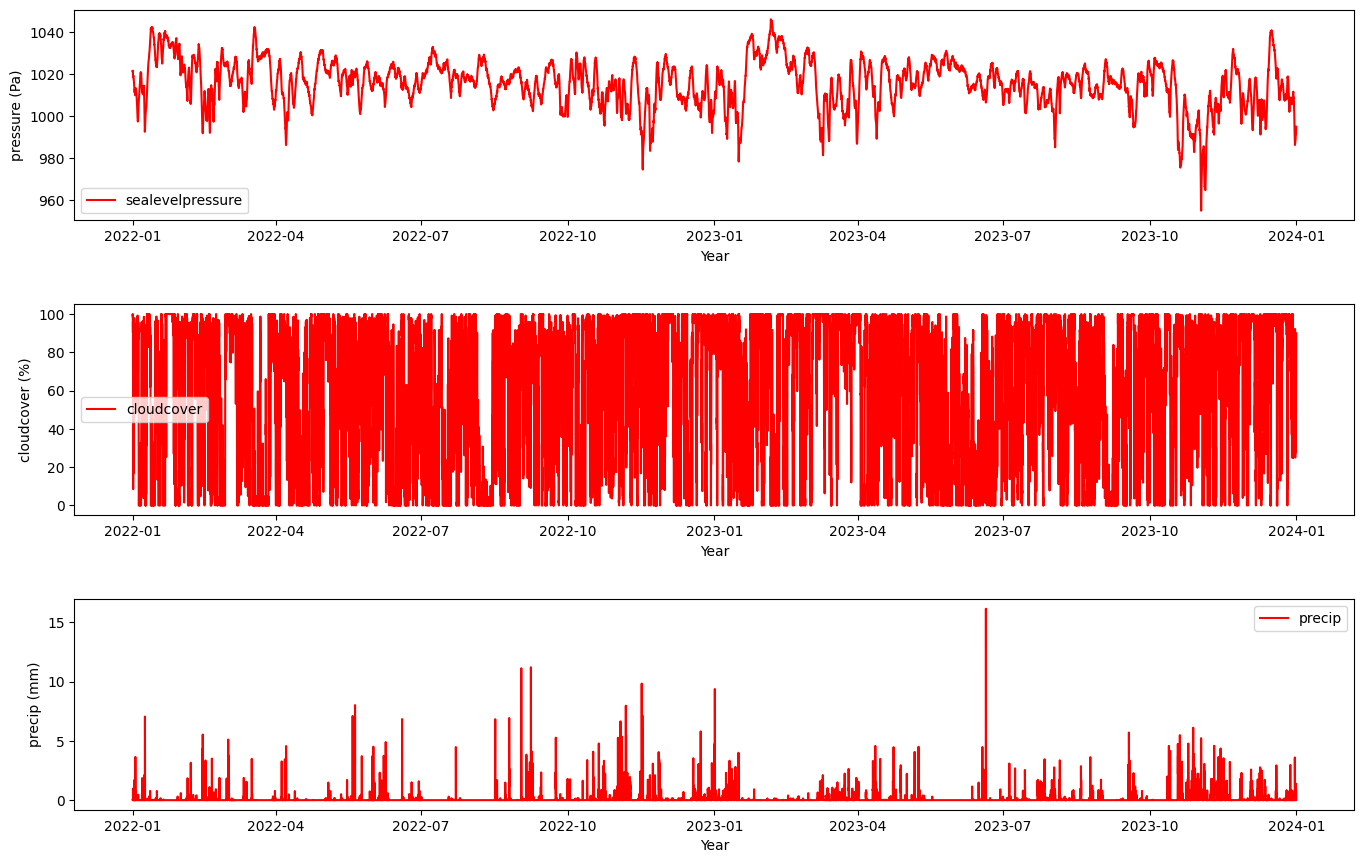

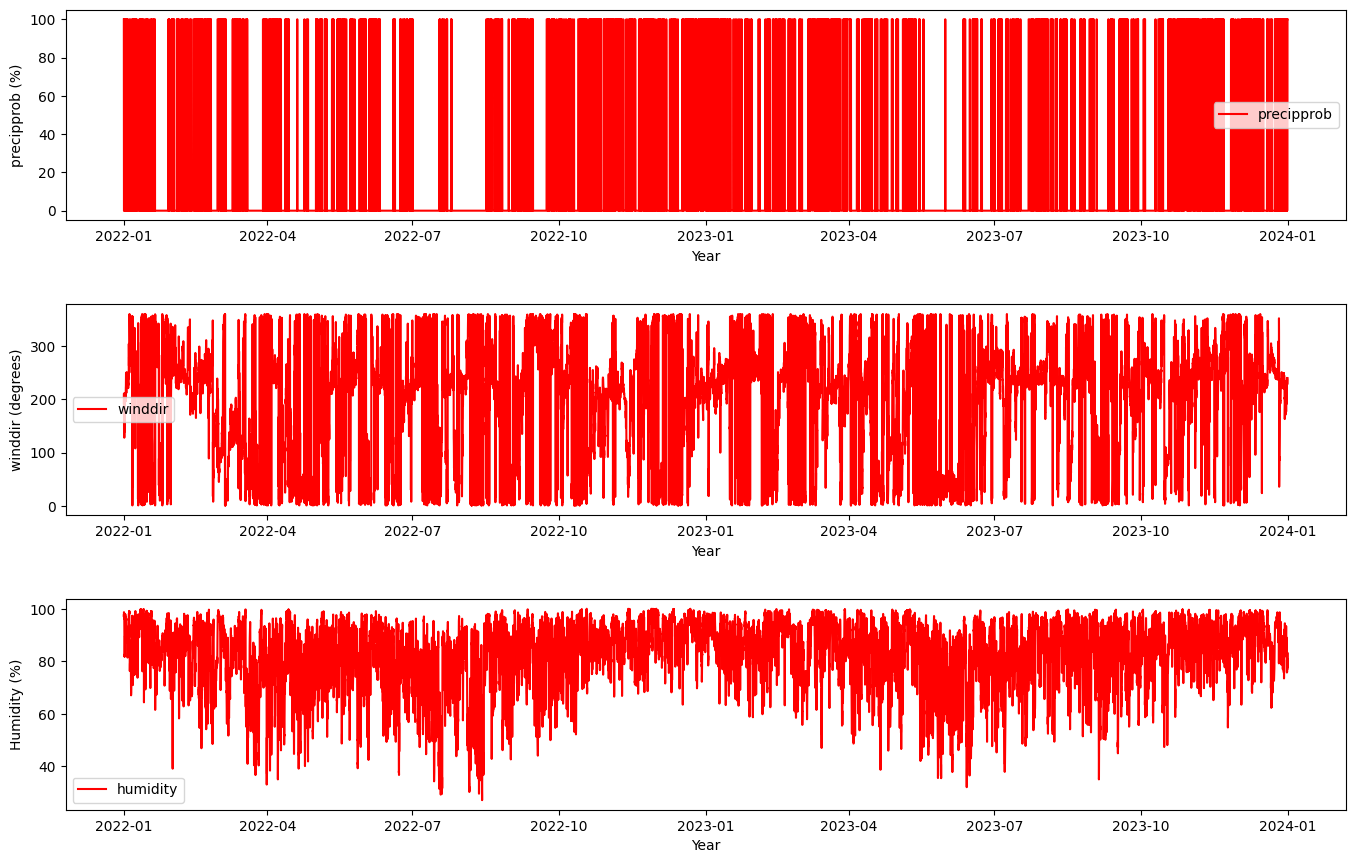

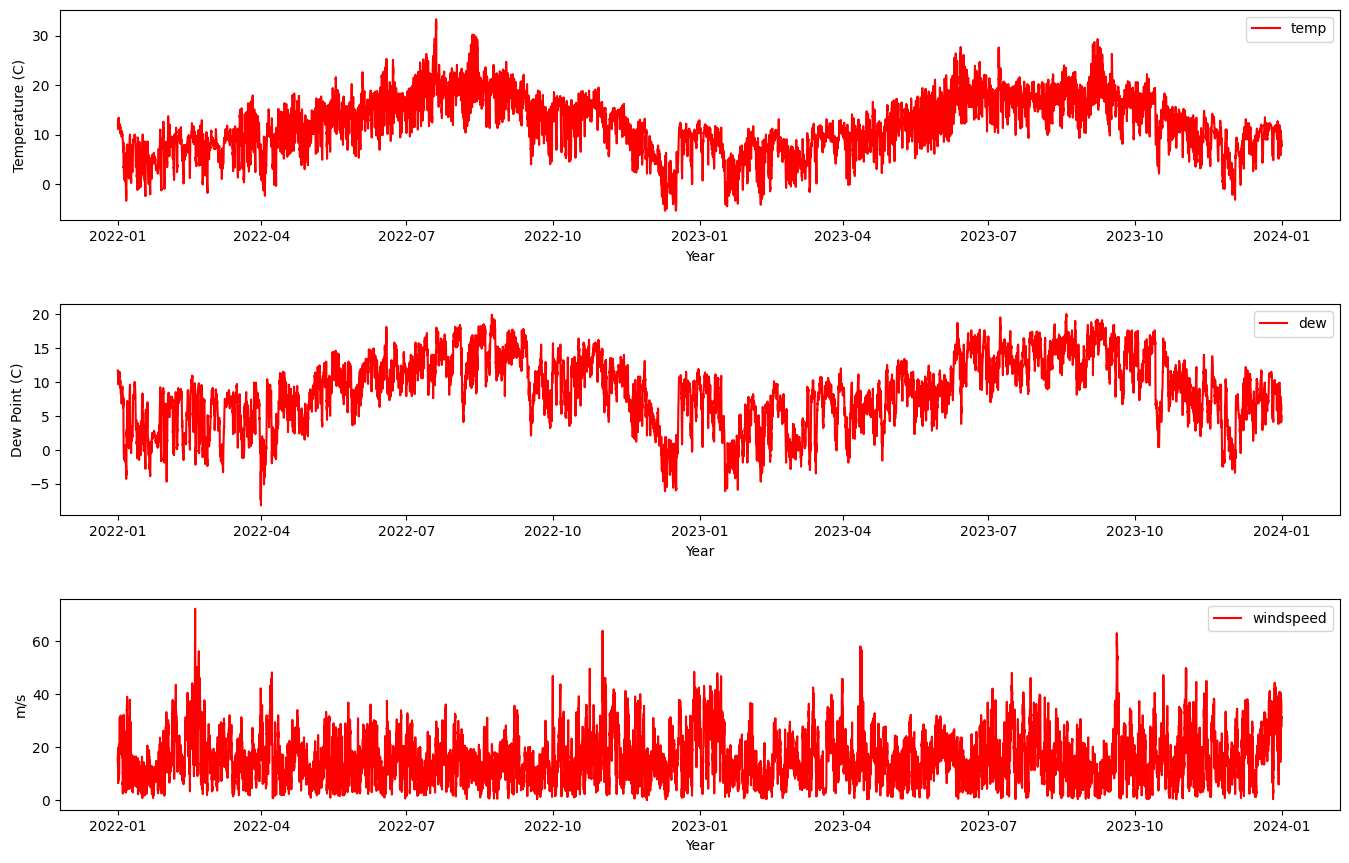

In [687]:
# plot val features and val label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(val_brighton_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])

plot(val_brighton_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])

plot(val_brighton_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s"],
     [])

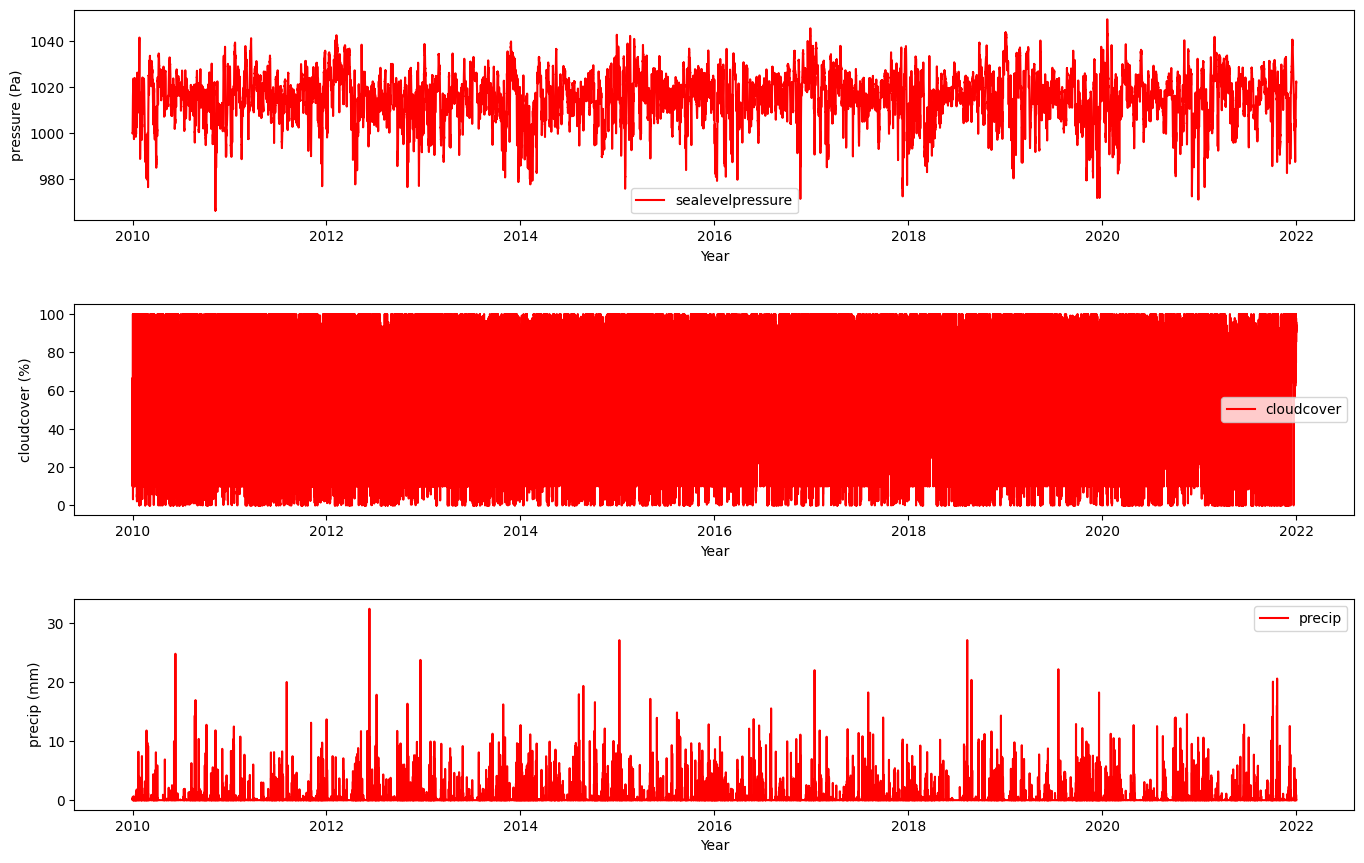

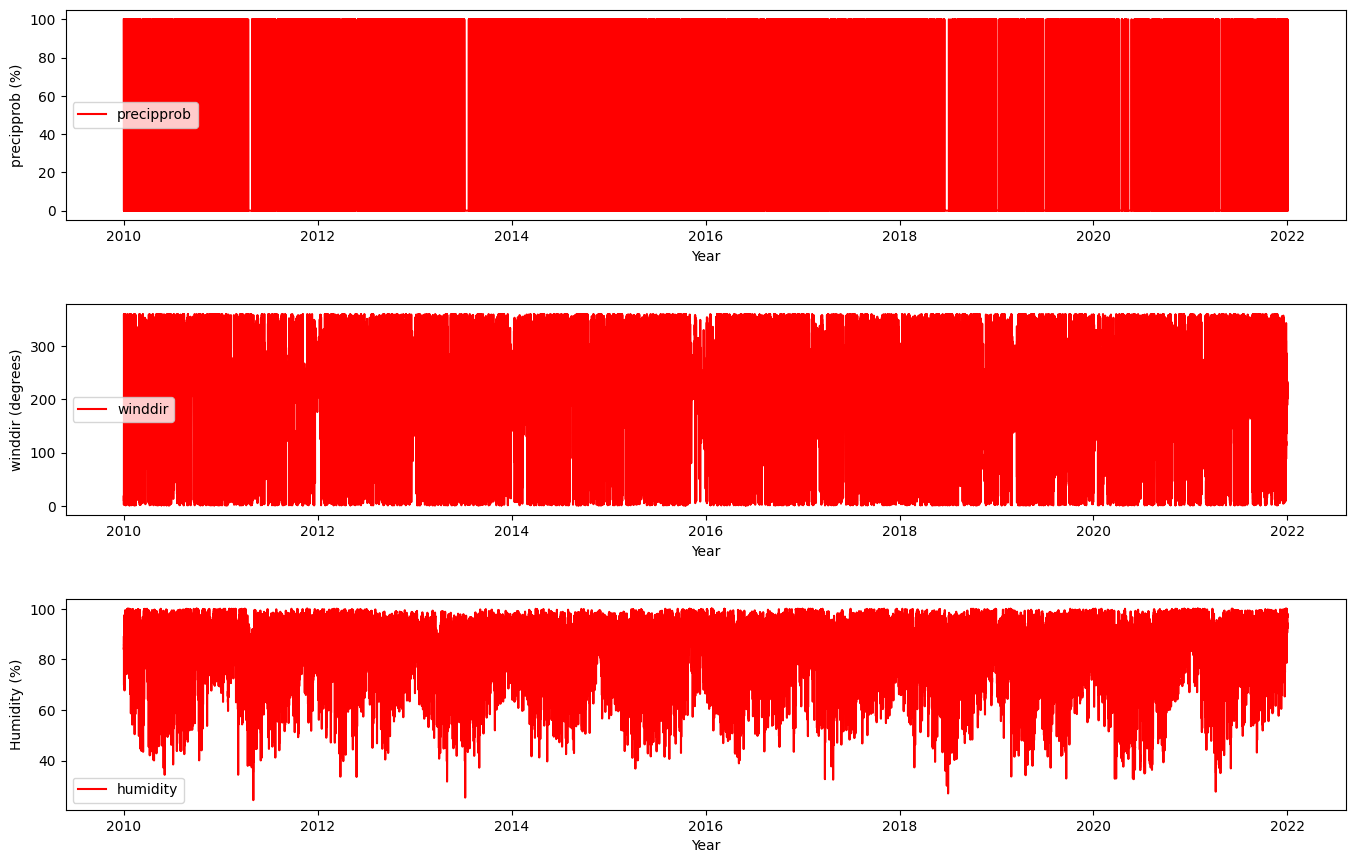

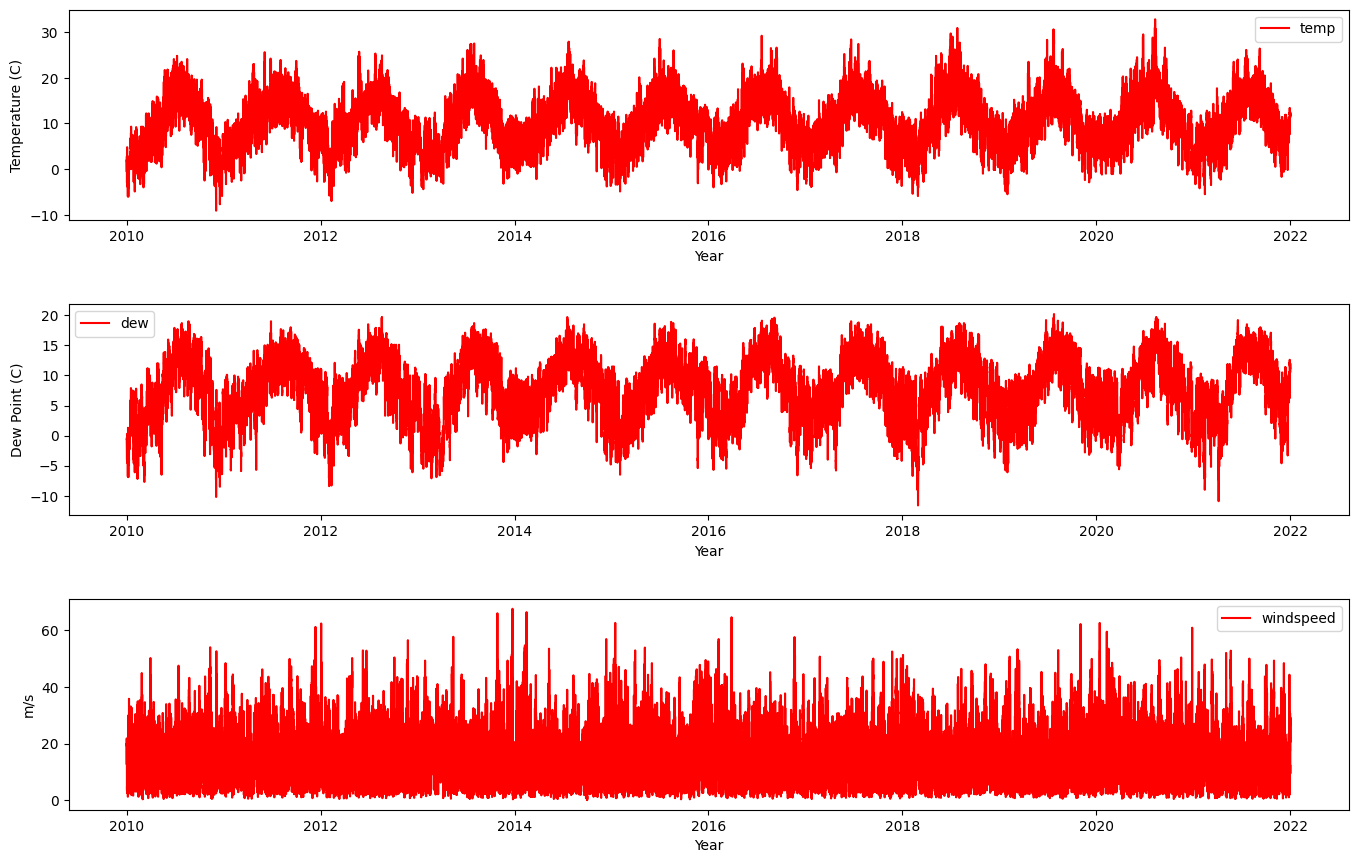

In [688]:
# plot train features and train label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(train_brighton_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])

plot(train_brighton_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])

plot(train_brighton_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s"],
     [])

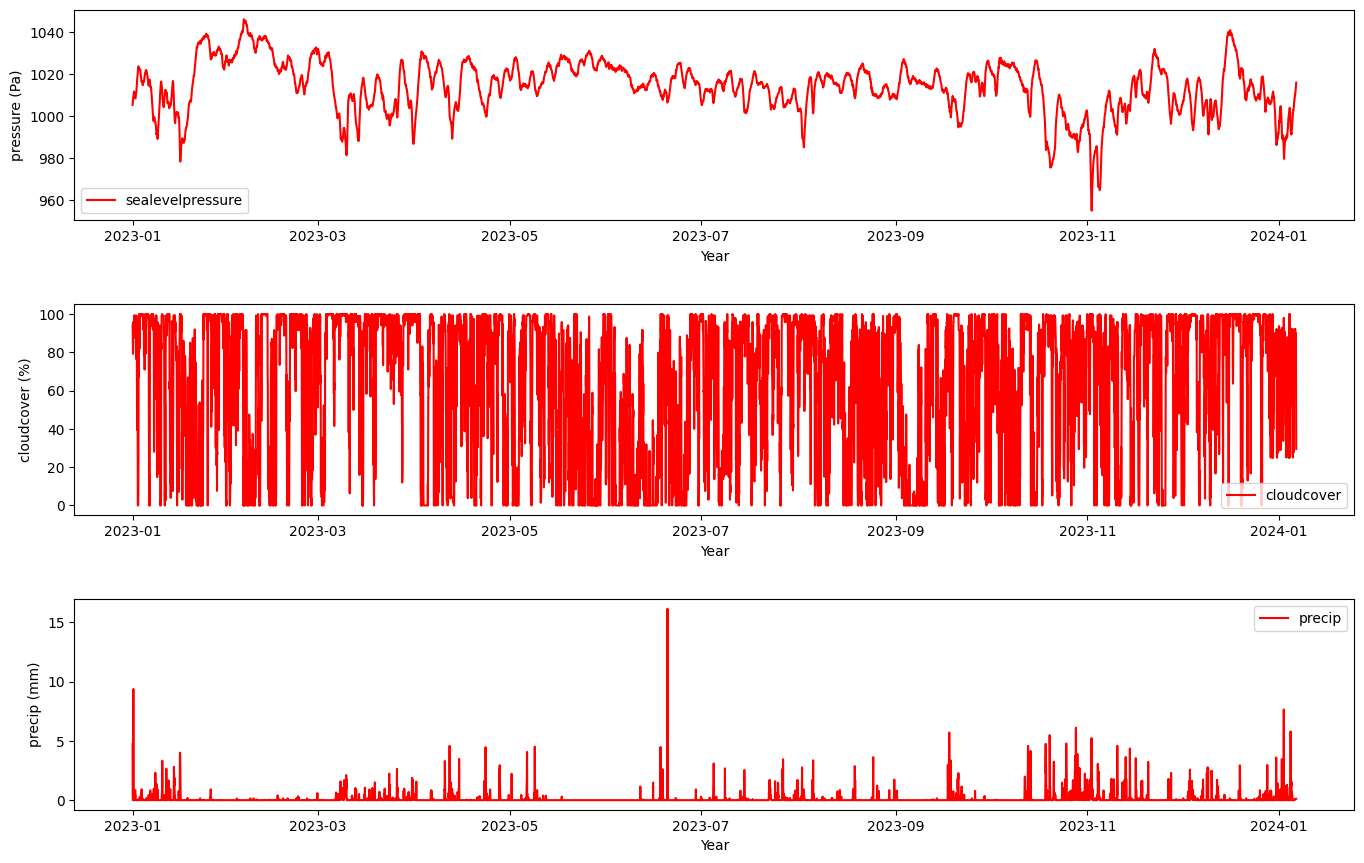

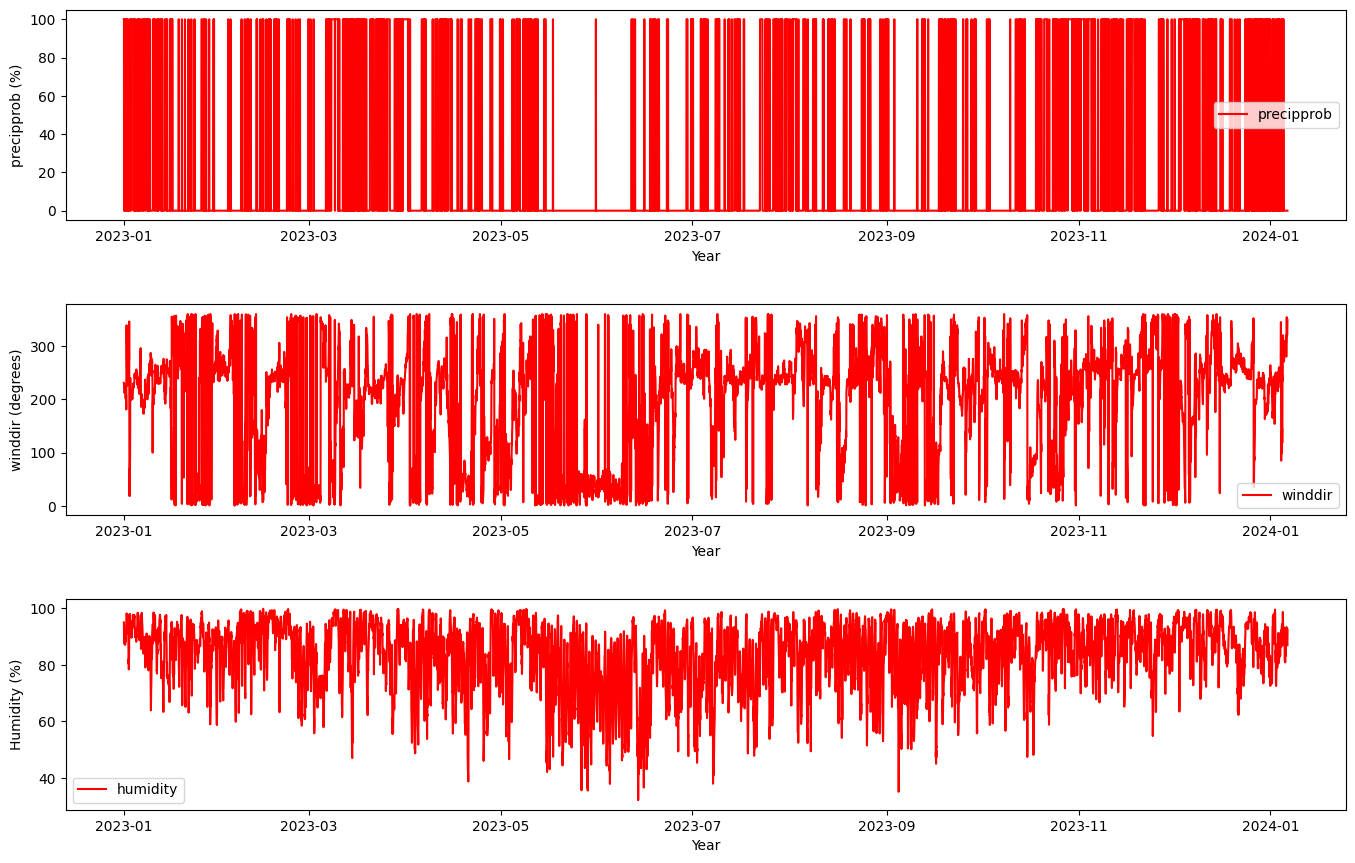

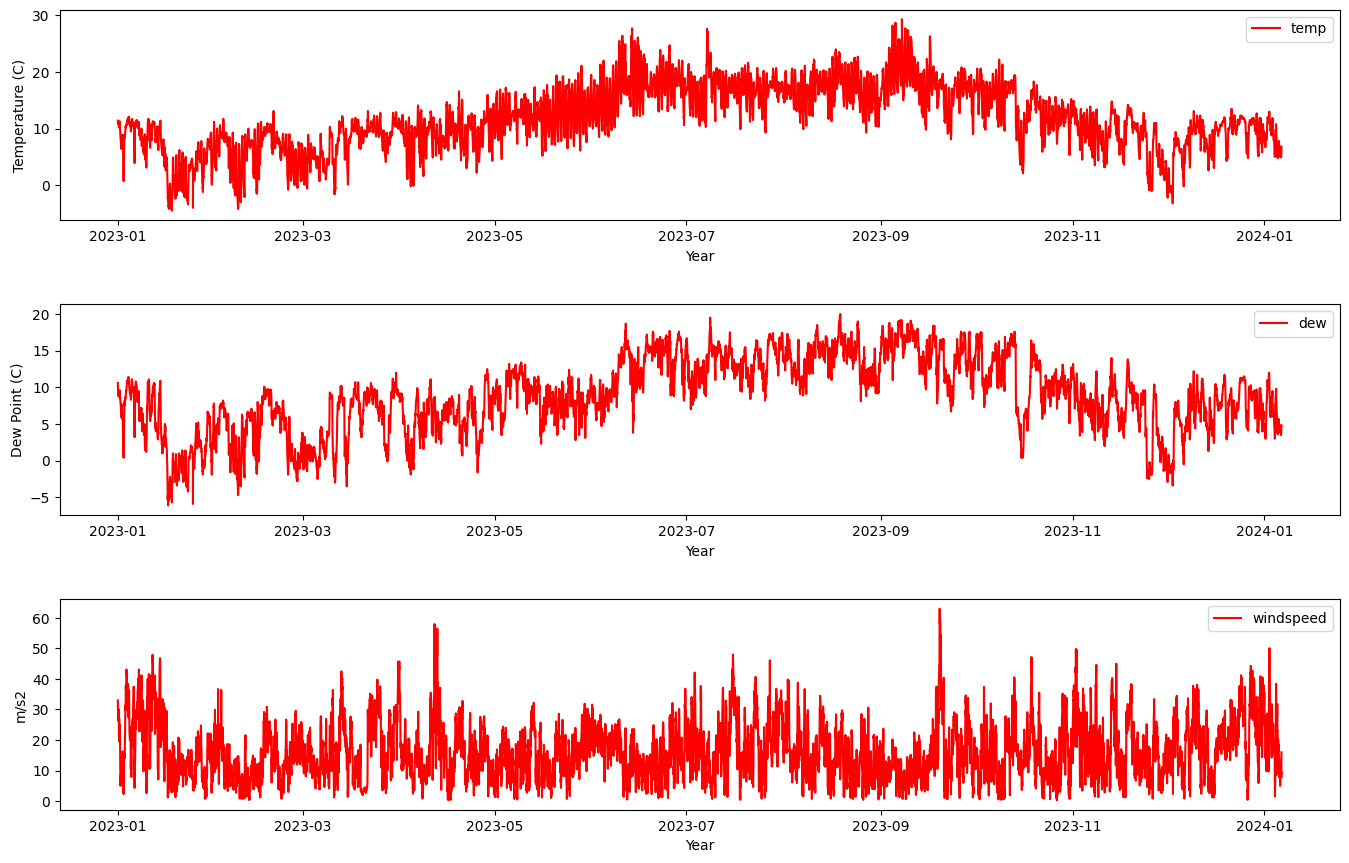

In [689]:
# plot test features and test label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(test_brighton_wind_df,
     ["sealevelpressure", "cloudcover", "precip"],
     ["pressure (Pa)", "cloudcover (%)", "precip (mm)"],
     [])

plot(test_brighton_wind_df,
     ["precipprob", "winddir", "humidity"],
     ["precipprob (%)", "winddir (degrees)", "Humidity (%)"],
     [])

plot(test_brighton_wind_df,
     ["temp", "dew", "windspeed"],
     ["Temperature (C)", "Dew Point (C)", "m/s2"],
     [])

## Impute missing values in validation dataset (solar)

In [690]:
df_lst = [[test_brighton_solar_df, test_label_brighton_solar_df, "./Data/test_brighton_solar_df.csv"],
         [val_brighton_solar_df, val_label_brighton_solar_df, "./Data/val_brighton_solar_df.csv"],
         [train_brighton_solar_df, train_label_brighton_solar_df, "./Data/train_brighton_solar_df.csv"]]

for df in df_lst:
    # impute missing values using polynomial interpolation
    df[0] = impute_missing_values(df[0])

    # replace any value for solarradiation during these hours with 0
    # solarradiation can have a value between 06:00 to 19:00
    df[1].loc[df[1].index.hour < 5,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 20,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 21,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 22,'solarradiation'] = 0
    df[1].loc[df[1].index.hour == 23,'solarradiation'] = 0
    
    # impute missing values using polynomial interpolation
    df[1] = impute_missing_values(df[1])

    assert df[0].isna().sum().sum() + df[1].isna().sum().sum() == 0

    df[0]['solarradiation'] = df[1]['solarradiation'].copy()

    df[0].to_csv(df[2])

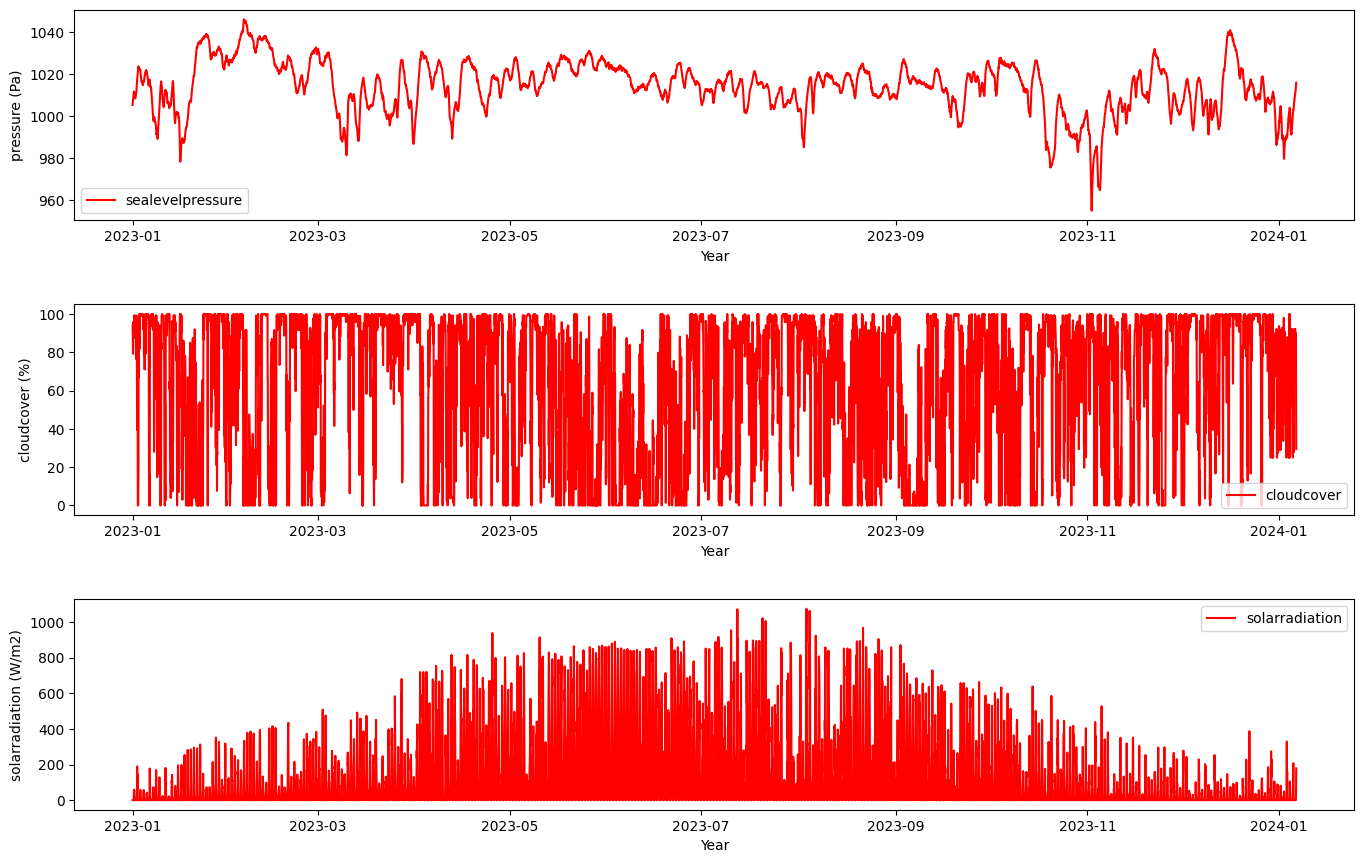

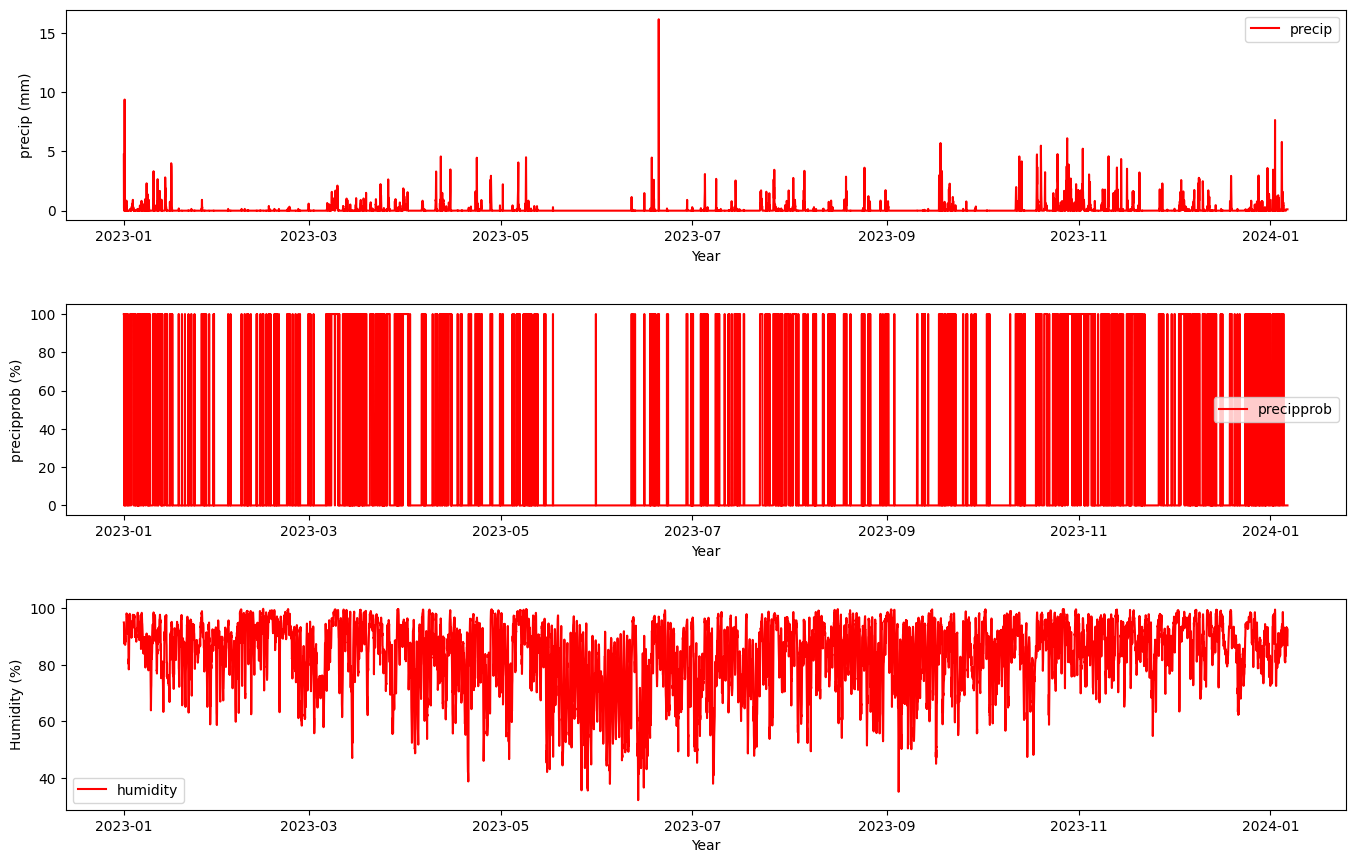

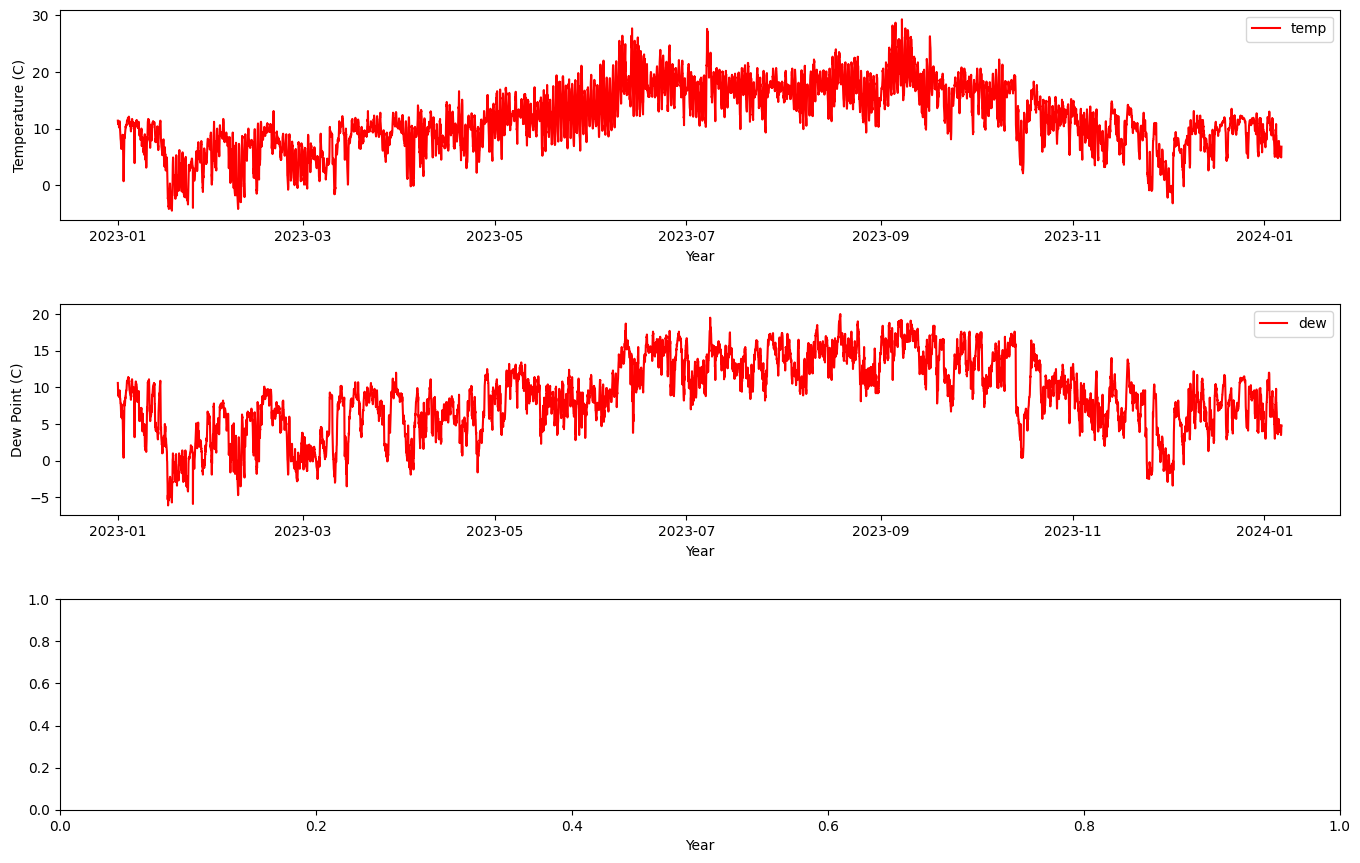

In [691]:
# plot test features and test label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(test_brighton_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(test_brighton_solar_df,
     ["precip", "precipprob", "humidity"],
     ["precip (mm)", "precipprob (%)", "Humidity (%)"],
     [])


plot(test_brighton_solar_df,
     ["temp", "dew", ""],
     ["Temperature (C)", "Dew Point (C)", ""],
     [])

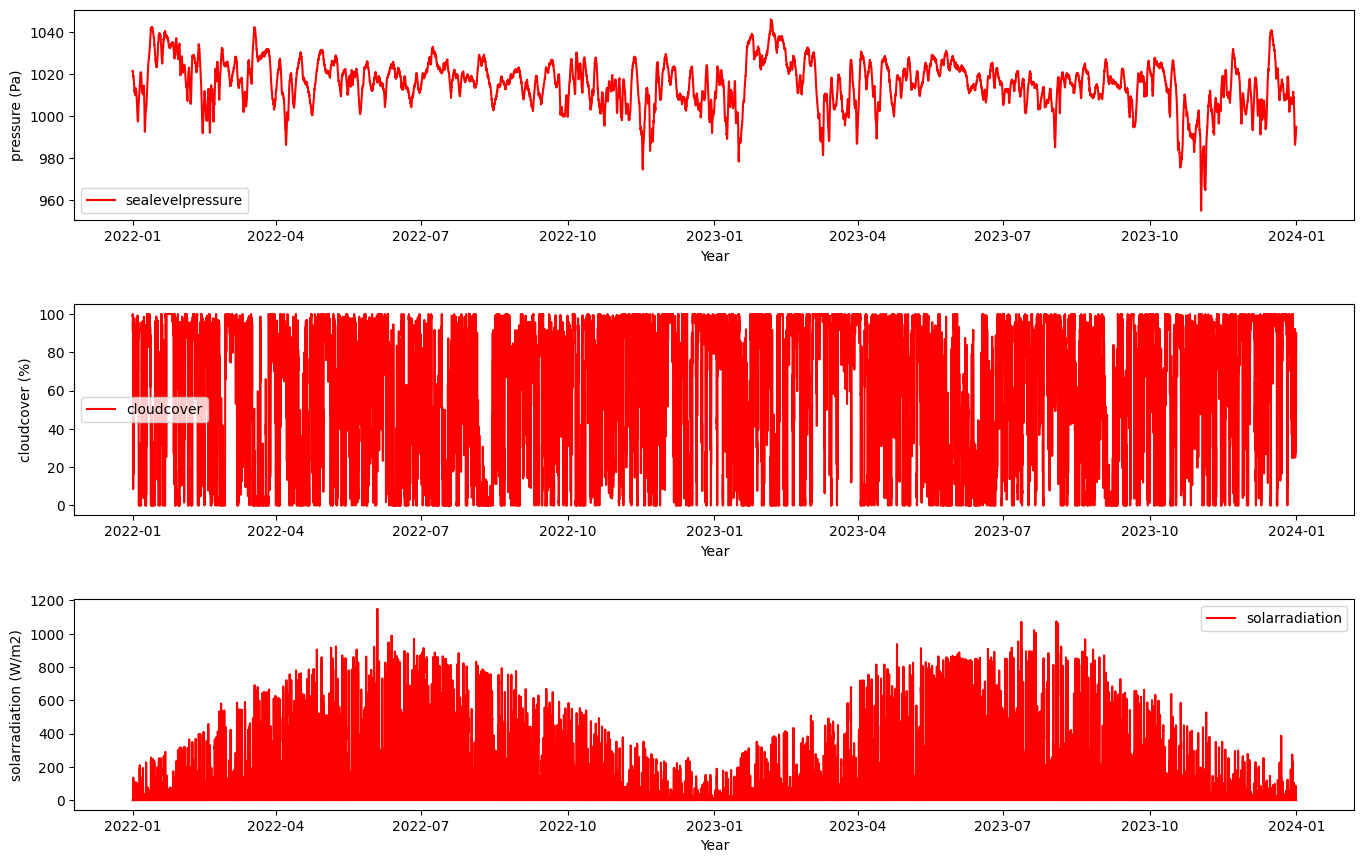

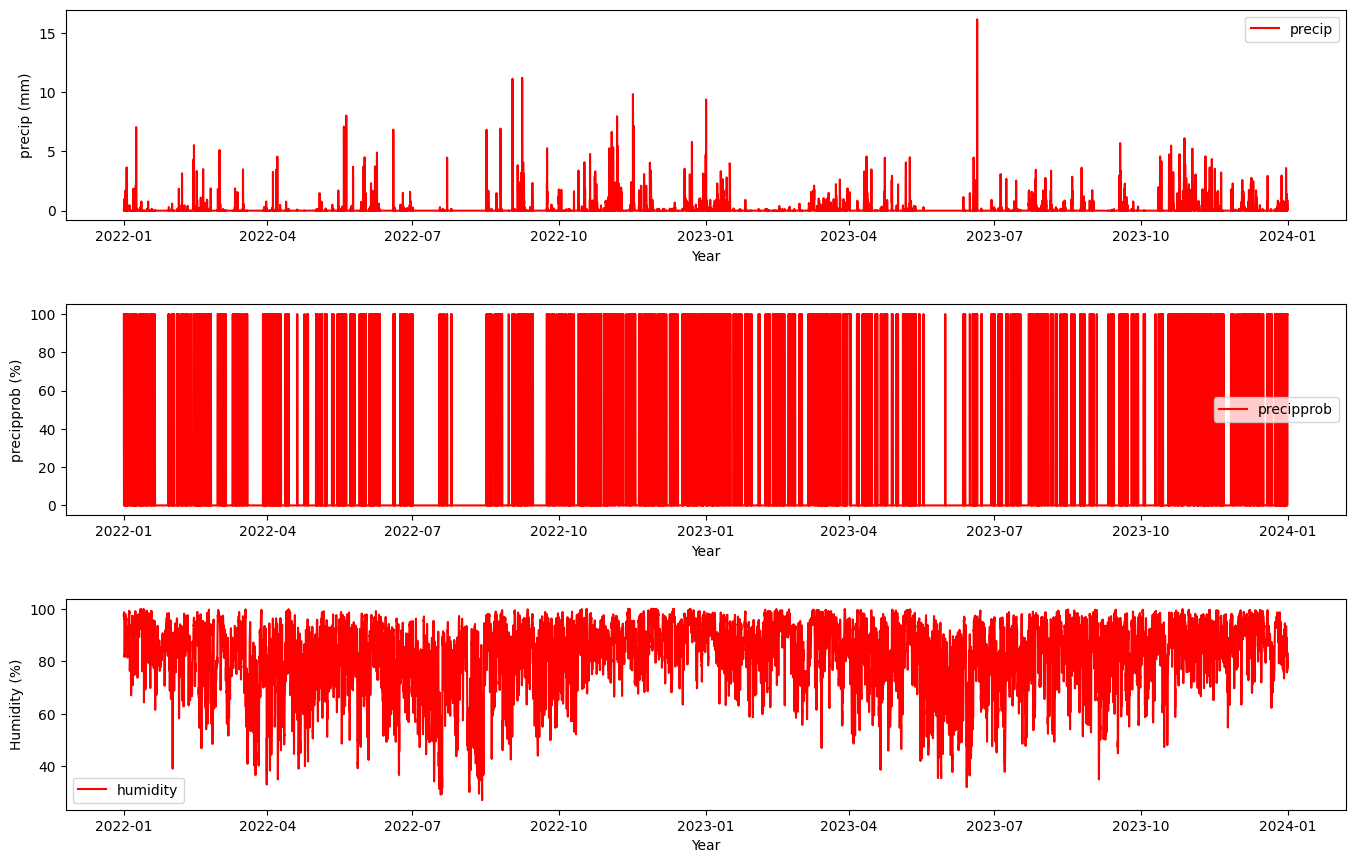

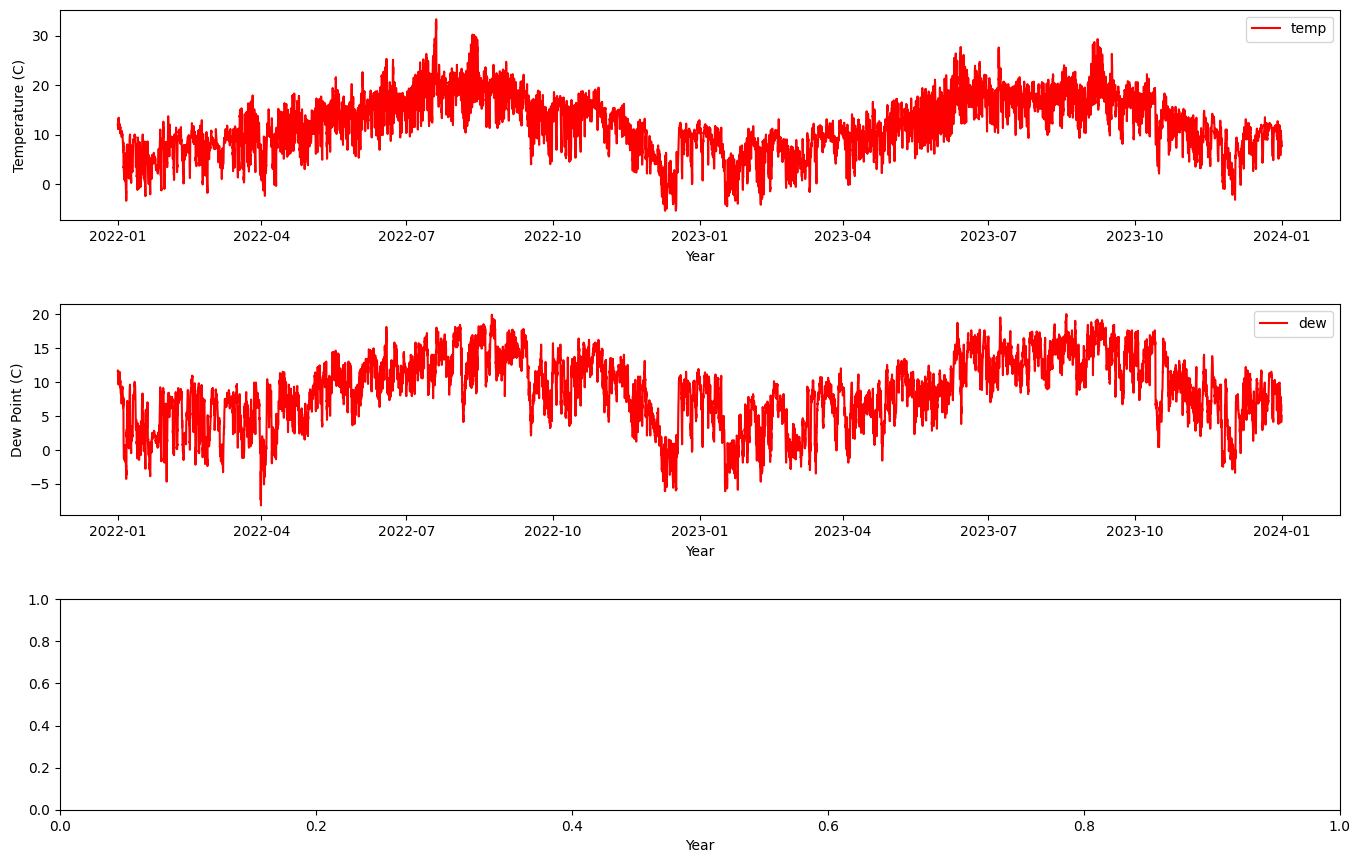

In [692]:
# plot val features and val label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(val_brighton_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(val_brighton_solar_df,
     ["precip", "precipprob", "humidity"],
     ["precip (mm)", "precipprob (%)", "Humidity (%)"],
     [])


plot(val_brighton_solar_df,
     ["temp", "dew", ""],
     ["Temperature (C)", "Dew Point (C)", ""],
     [])

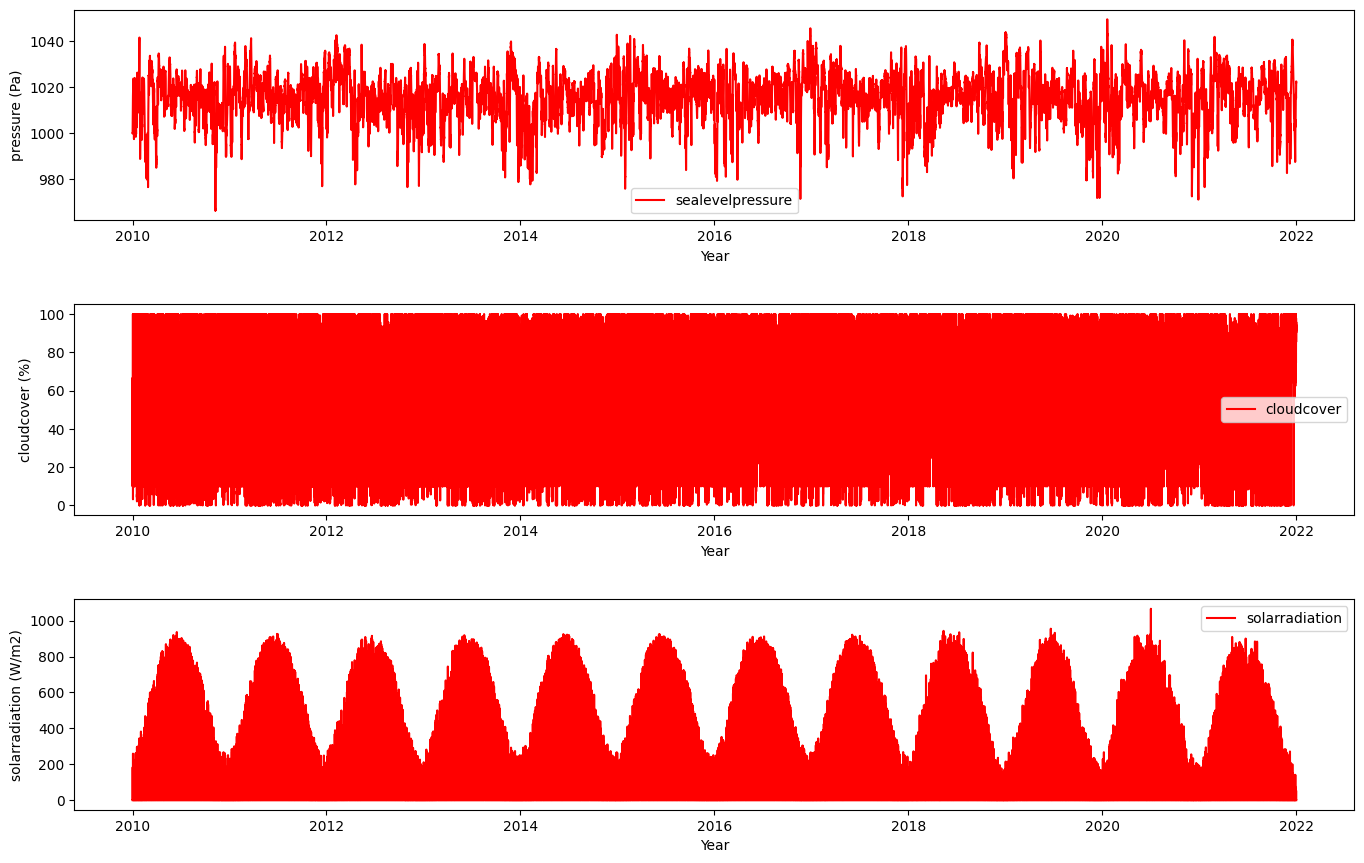

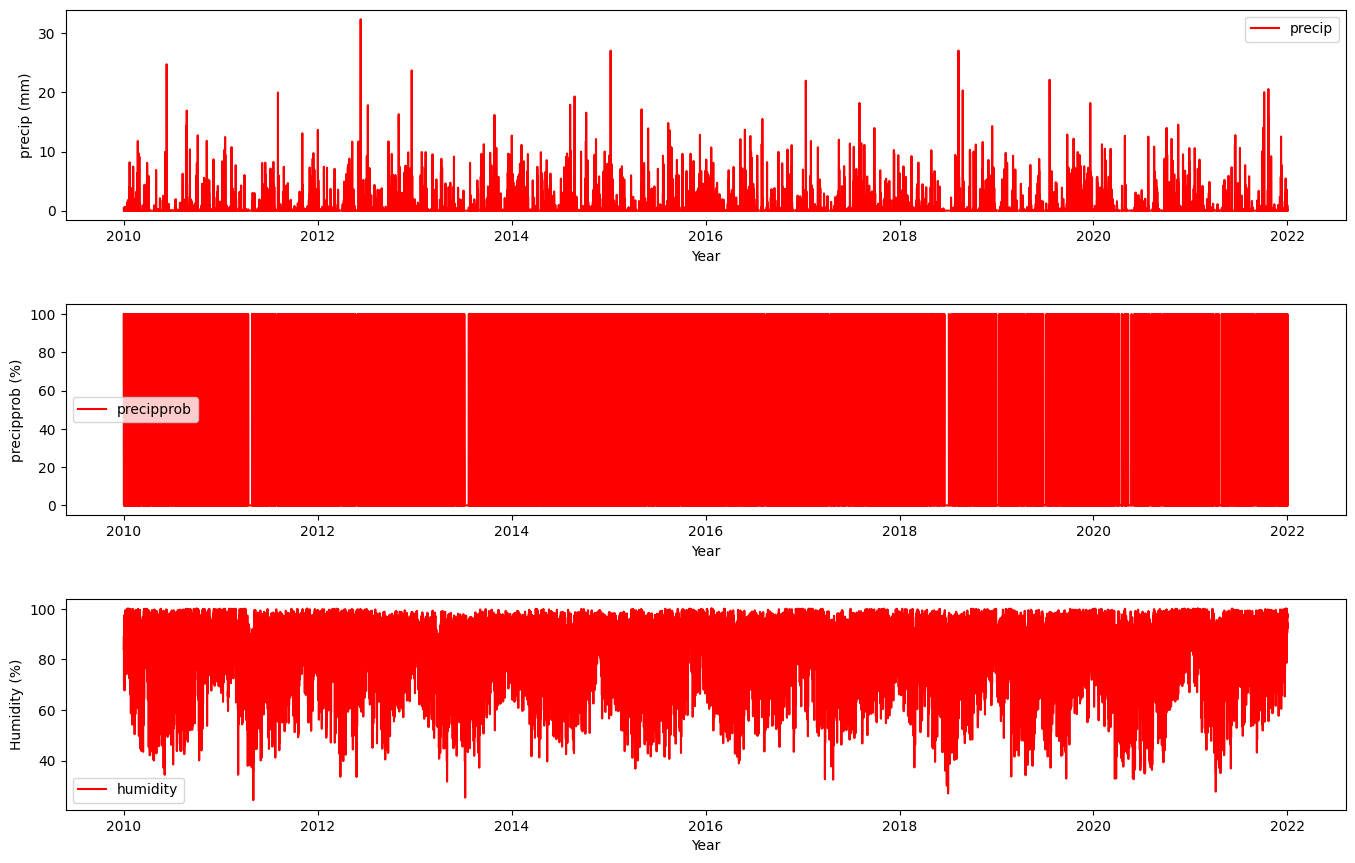

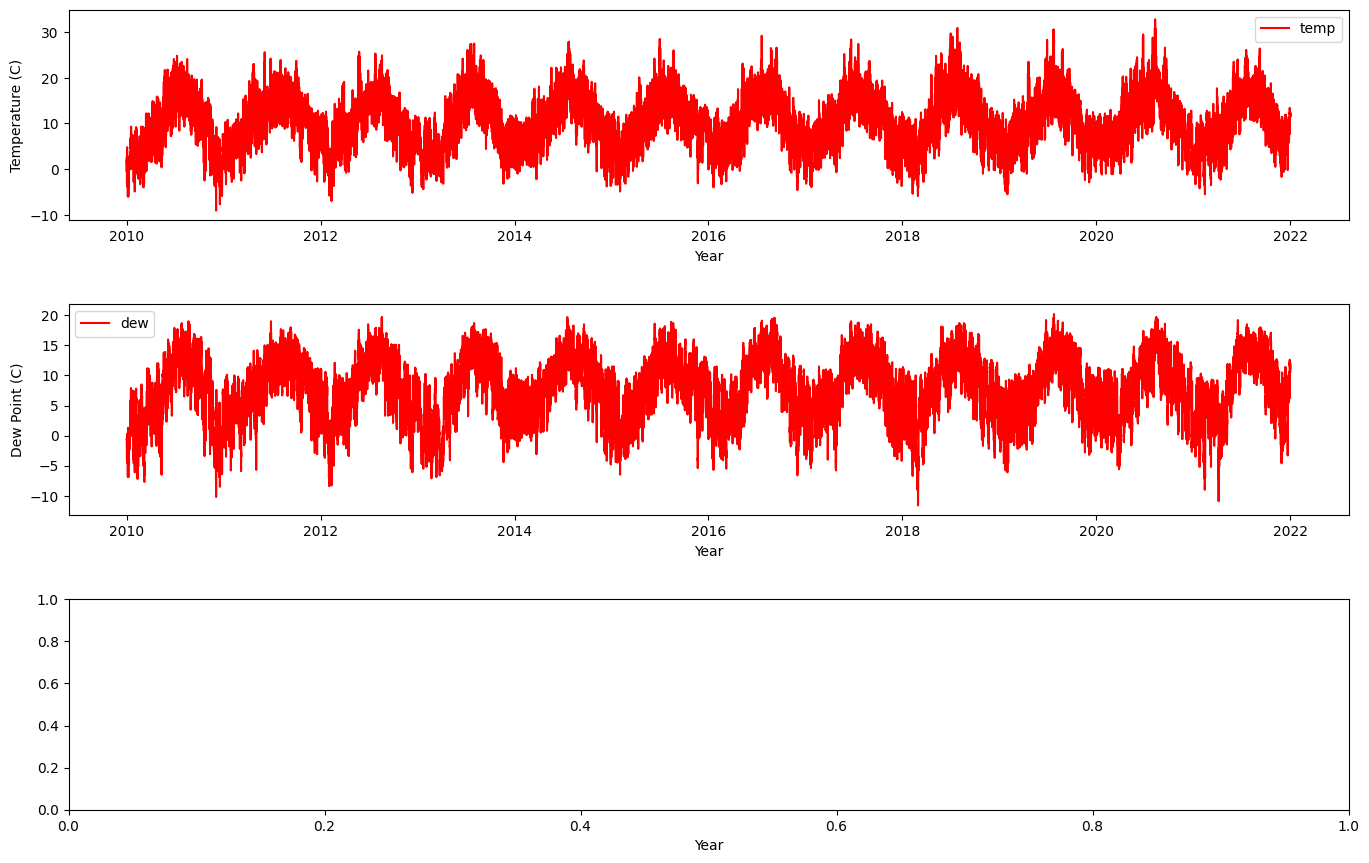

In [693]:
# plot train features and train label after preprocessing - cleaning, imputation, removing duplicates etc.
plot(train_brighton_solar_df,
     ["sealevelpressure", "cloudcover", "solarradiation"],
     ["pressure (Pa)", "cloudcover (%)", "solarradiation (W/m2)"],
     [])

plot(train_brighton_solar_df,
     ["precip", "precipprob", "humidity"],
     ["precip (mm)", "precipprob (%)", "Humidity (%)"],
     [])


plot(train_brighton_solar_df,
     ["temp", "dew", ""],
     ["Temperature (C)", "Dew Point (C)", ""],
     [])